using device: cpu

running language modeling experiments (problems 1 & 2)

experiment with seq len: 10

training transformer model, seq len=10


<ipython-input-1-8a90d9d41264>:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(sequences, dtype=torch.long)


epoch  1: train loss=3.1347, val loss=2.8129, val acc=0.2350
epoch  2: train loss=2.7733, val loss=2.6421, val acc=0.2490
epoch  3: train loss=2.6371, val loss=2.5592, val acc=0.2545
epoch  4: train loss=2.5430, val loss=2.4857, val acc=0.2811
epoch  5: train loss=2.4807, val loss=2.4419, val acc=0.2853
epoch  6: train loss=2.4518, val loss=2.4346, val acc=0.2909
epoch  7: train loss=2.4102, val loss=2.4179, val acc=0.2867
epoch  8: train loss=2.3570, val loss=2.4035, val acc=0.2839
epoch  9: train loss=2.3399, val loss=2.4028, val acc=0.3273
epoch 10: train loss=2.3462, val loss=2.3769, val acc=0.3063
epoch 11: train loss=2.3020, val loss=2.3931, val acc=0.3147
epoch 12: train loss=2.2813, val loss=2.3604, val acc=0.3147
epoch 13: train loss=2.2754, val loss=2.3607, val acc=0.3161
epoch 14: train loss=2.2484, val loss=2.3639, val acc=0.3217
epoch 15: train loss=2.2281, val loss=2.3374, val acc=0.3385
epoch 16: train loss=2.2029, val loss=2.3475, val acc=0.3315
epoch 17: train loss=2.2

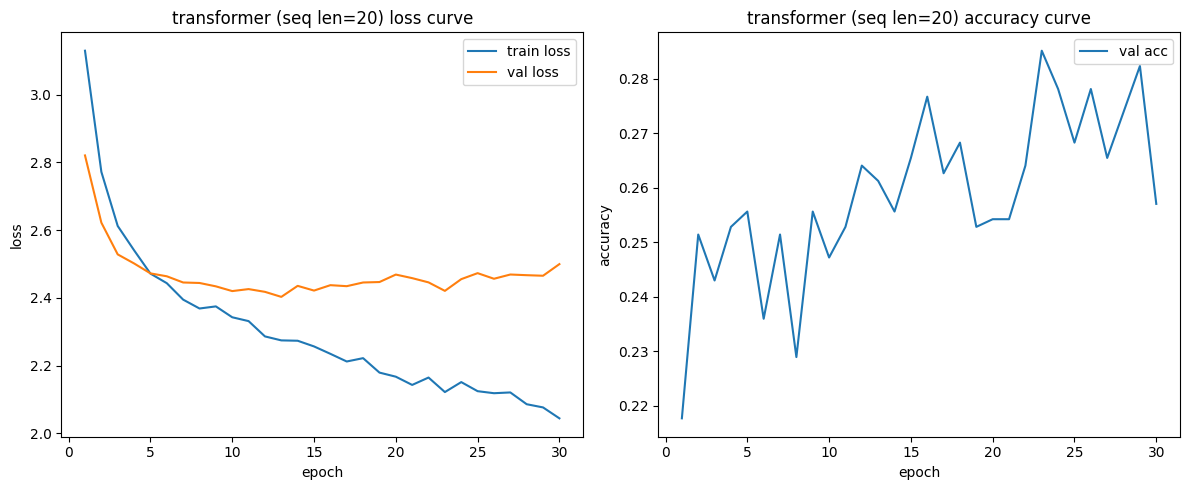


running translation experiments (problems 3 & 4)

transformer seq2seq experiments

transformer (layers=1, heads=2) for english-to-french
epoch  1: train loss=3.1696, val loss=3.0722, val acc=0.2500
epoch  2: train loss=2.7972, val loss=3.1960, val acc=0.0000
epoch  3: train loss=2.6692, val loss=3.3276, val acc=0.0000
epoch  4: train loss=2.5059, val loss=3.4583, val acc=0.0000
epoch  5: train loss=2.5307, val loss=3.5756, val acc=0.0000
epoch  6: train loss=2.2974, val loss=3.6890, val acc=0.0000
epoch  7: train loss=2.4724, val loss=3.7800, val acc=0.0000
epoch  8: train loss=2.0792, val loss=3.8575, val acc=0.0000
epoch  9: train loss=2.0350, val loss=3.9165, val acc=0.0000
epoch 10: train loss=1.9592, val loss=3.9669, val acc=0.0000
epoch 11: train loss=1.9333, val loss=4.0026, val acc=0.0000
epoch 12: train loss=1.9263, val loss=4.0314, val acc=0.0000
epoch 13: train loss=1.7228, val loss=4.0382, val acc=0.0000
epoch 14: train loss=1.6085, val loss=4.0392, val acc=0.0000
epoch 15

In [1]:
# homework 5: complete implementation for problems 1-4
# include your name, student id, and homework number in your report.
# link to your github repo in your report.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import time
import matplotlib.pyplot as plt
import random

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

# simple positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# simple plot function
def plot_metrics(metrics, title_prefix=""):
    epochs = len(metrics['train_loss'])
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), metrics['train_loss'], label="train loss")
    plt.plot(range(1, epochs+1), metrics['val_loss'], label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(f"{title_prefix} loss curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), metrics['val_acc'], label="val acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title(f"{title_prefix} accuracy curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

# preprocess text (lowercase)
def preprocess_text(text, lowercase=True):
    if lowercase:
        text = text.lower()
    return text

# create language model dataset
def create_lm_dataset(text, seq_length):
    chars = sorted(list(set(text)))
    char_to_int = {ch: i for i, ch in enumerate(chars)}
    int_to_char = {i: ch for i, ch in enumerate(chars)}
    vocab_size = len(chars)
    encoded = np.array([char_to_int[ch] for ch in text])
    sequences = []
    targets = []
    for i in range(len(encoded) - seq_length):
        sequences.append(encoded[i:i+seq_length])
        targets.append(encoded[i+seq_length])
    X = torch.tensor(sequences, dtype=torch.long)
    y = torch.tensor(targets, dtype=torch.long)
    return X, y, vocab_size, char_to_int, int_to_char

# language model dataset class
class LMTextDataset(Dataset):
    def __init__(self, sequences, targets):
        self.X = sequences
        self.y = targets

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# transformer language model (no cross-attention)
class TransformerLMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim,
                                                   nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x) * np.sqrt(self.embed.embedding_dim)
        x = self.pos_encoder(x)
        out = self.transformer_encoder(x)
        out = self.fc_out(out[:, -1, :])
        return out

# transformer with cross-attention
class TransformerLM_CrossModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim,
                                                   nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout,
                                                   batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim,
                                                   nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout,
                                                   batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.query_embed = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.embed(x) * np.sqrt(self.embed.embedding_dim)
        x = self.pos_encoder(x)
        memory = self.encoder(x)
        query = self.query_embed.expand(batch_size, -1, -1)
        dec_out = self.decoder(query, memory)
        out = self.fc_out(dec_out.squeeze(1))
        return out

# rnn language model (lstm)
class RNNLMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.lstm(x)
        out = self.fc_out(out[:, -1, :])
        return out

# train language model
def train_language_model(model, train_loader, val_loader, epochs=30, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    metrics = {"train_loss": [], "val_loss": [], "val_acc": []}
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        avg_train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == targets).sum().item()
                total += targets.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total

        metrics["train_loss"].append(avg_train_loss)
        metrics["val_loss"].append(avg_val_loss)
        metrics["val_acc"].append(val_acc)
        print(f"epoch {epoch+1:2d}: train loss={avg_train_loss:.4f}, val loss={avg_val_loss:.4f}, val acc={val_acc:.4f}")

    metrics["time"] = time.time() - start_time
    metrics["params"] = sum(p.numel() for p in model.parameters())
    return metrics

# run experiments for language modeling
def run_language_model_experiments():
    raw_text = """Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.

Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time.

Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants.

In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology."""

    text = preprocess_text(raw_text)
    seq_lengths = [10, 20, 30]
    model_types = {
        "transformer": TransformerLMModel,
        "transformer_cross": TransformerLM_CrossModel,
        "rnn_lstm": RNNLMModel
    }
    results = []

    for seq_len in seq_lengths:
        print(f"\nexperiment with seq len: {seq_len}")
        X, y, vocab_size, char_to_int, int_to_char = create_lm_dataset(text, seq_len)
        dataset = LMTextDataset(X, y)
        train_size = int(0.7 * len(dataset))
        val_size = len(dataset) - train_size
        train_set, val_set = random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

        for name, model_class in model_types.items():
            print(f"\ntraining {name} model, seq len={seq_len}")
            model = model_class(vocab_size=vocab_size).to(device)
            metrics = train_language_model(model, train_loader, val_loader, epochs=30, lr=0.001)
            metrics['model'] = name
            metrics['seq_len'] = seq_len
            results.append(metrics)
            print(f"final: {name} (seq len={seq_len}), val acc={metrics['val_acc'][-1]:.4f}, time={metrics['time']:.1f}s, params={metrics['params']}")

    sample = next(r for r in results if r['model'] == "transformer" and r['seq_len'] == 20)
    plot_metrics(sample, title_prefix="transformer (seq len=20)")
    return results

# translation data: dummy data for english-french
def build_translation_data():
    eng = [
        "hello how are you",
        "i am fine thank you",
        "what is your name",
        "nice to meet you",
        "have a good day"
    ]
    fr = [
        "bonjour comment ca va",
        "je vais bien merci",
        "quel est ton nom",
        "ravi de te rencontrer",
        "bonne journee"
    ]
    return eng, fr

# tokenize sentences
def tokenize(sentences, token2idx=None):
    tokenized = [sent.split() for sent in sentences]
    if token2idx is None:
        vocab = set(word for sent in tokenized for word in sent)
        token2idx = {word: idx+2 for idx, word in enumerate(sorted(vocab))}
        token2idx["<pad>"] = 0
        token2idx["<sos>"] = 1
    tokenized_idx = [[token2idx[word] for word in sent] for sent in tokenized]
    return tokenized_idx, token2idx

# pad sequences
def pad_sequences(sequences, max_len):
    padded = []
    for seq in sequences:
        seq = seq[:max_len]
        seq = seq + [0]*(max_len - len(seq))
        padded.append(seq)
    return torch.tensor(padded, dtype=torch.long)

# translation dataset class
class TranslationDataset(Dataset):
    def __init__(self, src_seqs, tgt_seqs, src_max_len, tgt_max_len):
        self.src = pad_sequences(src_seqs, src_max_len)
        self.tgt = pad_sequences([[1] + seq for seq in tgt_seqs], tgt_max_len)

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

# transformer seq2seq model
class TransformerSeq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim=64, nhead=2, num_layers=2,
                 dim_feedforward=128, dropout=0.2):
        super().__init__()
        self.src_embed = nn.Embedding(src_vocab_size, embed_dim)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout=dropout)
        self.transformer = nn.Transformer(d_model=embed_dim,
                                          nhead=nhead,
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout,
                                          batch_first=True)
        self.fc_out = nn.Linear(embed_dim, tgt_vocab_size)

    def forward(self, src, tgt):
        src_emb = self.pos_encoder(self.src_embed(src) * np.sqrt(self.src_embed.embedding_dim))
        tgt_emb = self.pos_encoder(self.tgt_embed(tgt) * np.sqrt(self.tgt_embed.embedding_dim))
        out = self.transformer(src_emb, tgt_emb)
        out = self.fc_out(out)
        return out

# simple rnn encoder
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_layers, dropout=0.2):
        super().__init__()
        self.embed = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)

    def forward(self, src):
        embedded = self.embed(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

# simple attention
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

# simple rnn decoder with attention
class RNNDecoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers, dropout=0.2):
        super().__init__()
        self.embed = nn.Embedding(output_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim + hidden_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.attention = Attention(hidden_dim)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embed(input)
        attn_weights = self.attention(hidden[0][-1], encoder_outputs)
        attn_weights = attn_weights.unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        output = output.squeeze(1)
        context = context.squeeze(1)
        prediction = self.fc_out(torch.cat((output, context), dim=1))
        return prediction, hidden

# seq2seq rnn model
class Seq2SeqRNN(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        tgt_len = tgt.size(1)
        tgt_vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = tgt[:, 0]
        for t in range(1, tgt_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t, :] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = tgt[:, t] if teacher_force else top1
        return outputs

# train translation model
def train_translation_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    metrics = {"train_loss": [], "val_loss": [], "val_acc": []}
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for src, tgt in train_loader:
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            output = model(src, tgt[:, :-1])
            loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * src.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        metrics["train_loss"].append(avg_loss)

        model.eval()
        total_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for src, tgt in val_loader:
                src, tgt = src.to(device), tgt.to(device)
                output = model(src, tgt[:, :-1])
                loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
                total_loss += loss.item() * src.size(0)
                preds = output.argmax(dim=2)
                correct += (preds == tgt[:, 1:]).sum().item()
                total += np.prod(tgt[:, 1:].shape)
        val_loss = total_loss / len(val_loader.dataset)
        val_acc = correct / total
        metrics["val_loss"].append(val_loss)
        metrics["val_acc"].append(val_acc)

        print(f"epoch {epoch+1:2d}: train loss={avg_loss:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")

    metrics["time"] = time.time() - start_time
    metrics["params"] = sum(p.numel() for p in model.parameters())
    return metrics

# run experiments for translation tasks
def run_translation_experiments():
    eng_sentences, fr_sentences = build_translation_data()
    eng_tokens, eng_token2idx = tokenize(eng_sentences)
    fr_tokens, fr_token2idx = tokenize(fr_sentences)
    src_max_len = max(len(s) for s in eng_tokens) + 1
    tgt_max_len = max(len(s) for s in fr_tokens) + 1
    dataset_en_fr = TranslationDataset(eng_tokens, fr_tokens, src_max_len, tgt_max_len)
    dataset_fr_en = TranslationDataset(fr_tokens, eng_tokens, src_max_len, tgt_max_len)

    def split_dataset(dataset):
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        return random_split(dataset, [train_size, val_size])

    train_en_fr, val_en_fr = split_dataset(dataset_en_fr)
    train_fr_en, val_fr_en = split_dataset(dataset_fr_en)

    batch_size = 2
    train_loader_en_fr = DataLoader(train_en_fr, batch_size=batch_size, shuffle=True)
    val_loader_en_fr = DataLoader(val_en_fr, batch_size=batch_size, shuffle=False)
    train_loader_fr_en = DataLoader(train_fr_en, batch_size=batch_size, shuffle=True)
    val_loader_fr_en = DataLoader(val_fr_en, batch_size=batch_size, shuffle=False)

    layer_configs = [1, 2, 4]
    head_configs = [2, 4]
    results = {"transformer_en_fr": [], "transformer_fr_en": [], "rnn_en_fr": [], "rnn_fr_en": []}

    print("\ntransformer seq2seq experiments")
    for num_layers in layer_configs:
        for nhead in head_configs:
            print(f"\ntransformer (layers={num_layers}, heads={nhead}) for english-to-french")
            model = TransformerSeq2Seq(src_vocab_size=len(eng_token2idx),
                                       tgt_vocab_size=len(fr_token2idx),
                                       embed_dim=64,
                                       nhead=nhead,
                                       num_layers=num_layers,
                                       dim_feedforward=128,
                                       dropout=0.2).to(device)
            metrics = train_translation_model(model, train_loader_en_fr, val_loader_en_fr, epochs=15, lr=0.001)
            metrics['config'] = f"layers={num_layers}, heads={nhead}"
            results["transformer_en_fr"].append(metrics)

            print(f"\ntransformer (layers={num_layers}, heads={nhead}) for french-to-english")
            model_rev = TransformerSeq2Seq(src_vocab_size=len(fr_token2idx),
                                           tgt_vocab_size=len(eng_token2idx),
                                           embed_dim=64,
                                           nhead=nhead,
                                           num_layers=num_layers,
                                           dim_feedforward=128,
                                           dropout=0.2).to(device)
            metrics_rev = train_translation_model(model_rev, train_loader_fr_en, val_loader_fr_en, epochs=15, lr=0.001)
            metrics_rev['config'] = f"layers={num_layers}, heads={nhead}"
            results["transformer_fr_en"].append(metrics_rev)

    print("\nrnn seq2seq (with attention) experiments")
    hidden_dim = 128
    num_layers = 2
    for direction in ["en_fr", "fr_en"]:
        if direction == "en_fr":
            train_loader, val_loader = train_loader_en_fr, val_loader_en_fr
            src_vocab_size = len(eng_token2idx)
            tgt_vocab_size = len(fr_token2idx)
        else:
            train_loader, val_loader = train_loader_fr_en, val_loader_fr_en
            src_vocab_size = len(fr_token2idx)
            tgt_vocab_size = len(eng_token2idx)
        encoder = RNNEncoder(src_vocab_size, embed_dim=64, hidden_dim=hidden_dim, num_layers=num_layers, dropout=0.2)
        decoder = RNNDecoder(tgt_vocab_size, embed_dim=64, hidden_dim=hidden_dim, num_layers=num_layers, dropout=0.2)
        model_rnn = Seq2SeqRNN(encoder, decoder, device).to(device)
        print(f"\nrnn seq2seq for {direction} translation")
        metrics_rnn = train_translation_model(model_rnn, train_loader, val_loader, epochs=15, lr=0.001)
        results[f"rnn_{direction}"].append(metrics_rnn)

    print("\nsample english-to-french translation (transformer):")
    sample_sentence = "hello how are you".split()
    sample_indices = [eng_token2idx[word] for word in sample_sentence]
    sample_tensor = pad_sequences([sample_indices], max_len=src_max_len).to(device)
    tgt_init = torch.tensor([[1]], dtype=torch.long).to(device)
    model_best = TransformerSeq2Seq(src_vocab_size=len(eng_token2idx),
                                    tgt_vocab_size=len(fr_token2idx),
                                    embed_dim=64,
                                    nhead=2,
                                    num_layers=2,
                                    dim_feedforward=128,
                                    dropout=0.2).to(device)
    model_best.eval()
    with torch.no_grad():
        generated = [1]
        for _ in range(5):
            tgt_input = torch.tensor([generated], dtype=torch.long).to(device)
            output = model_best(sample_tensor, tgt_input)
            next_token = output[:, -1, :].argmax(dim=1).item()
            generated.append(next_token)
    print("input (english):", " ".join(sample_sentence))
    inv_fr = {v: k for k, v in fr_token2idx.items()}
    generated_words = [inv_fr.get(tok, "<unk>") for tok in generated[1:]]
    print("generated (french):", " ".join(generated_words))

    return results

# main execution
if __name__ == '__main__':
    print("\nrunning language modeling experiments (problems 1 & 2)")
    lm_results = run_language_model_experiments()

    print("\nrunning translation experiments (problems 3 & 4)")
    translation_results = run_translation_experiments()




using device: cpu

=== sequence length: 10 ===

training transformer, seq_len=10
epoch 1/30 - train loss: 3.1230 | val loss: 2.7994 | val acc: 0.2028
epoch 2/30 - train loss: 2.7064 | val loss: 2.6038 | val acc: 0.2601
epoch 3/30 - train loss: 2.5284 | val loss: 2.5308 | val acc: 0.2671
epoch 4/30 - train loss: 2.4493 | val loss: 2.5213 | val acc: 0.2615
epoch 5/30 - train loss: 2.3901 | val loss: 2.4929 | val acc: 0.2769
epoch 6/30 - train loss: 2.3292 | val loss: 2.4788 | val acc: 0.2769
epoch 7/30 - train loss: 2.2781 | val loss: 2.4728 | val acc: 0.2657
epoch 8/30 - train loss: 2.2165 | val loss: 2.4434 | val acc: 0.3007
epoch 9/30 - train loss: 2.2437 | val loss: 2.4229 | val acc: 0.3091
epoch 10/30 - train loss: 2.2040 | val loss: 2.4250 | val acc: 0.2965
epoch 11/30 - train loss: 2.1604 | val loss: 2.4035 | val acc: 0.3343
epoch 12/30 - train loss: 2.1125 | val loss: 2.4174 | val acc: 0.3203
epoch 13/30 - train loss: 2.1000 | val loss: 2.4495 | val acc: 0.3035
epoch 14/30 - trai

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


epoch 1/30 - train loss: 3.2596 | val loss: 2.8643 | val acc: 0.1622
epoch 2/30 - train loss: 2.7908 | val loss: 2.7216 | val acc: 0.2531
epoch 3/30 - train loss: 2.6206 | val loss: 2.6092 | val acc: 0.2825
epoch 4/30 - train loss: 2.4565 | val loss: 2.5099 | val acc: 0.2979
epoch 5/30 - train loss: 2.3241 | val loss: 2.4392 | val acc: 0.3301
epoch 6/30 - train loss: 2.2300 | val loss: 2.3865 | val acc: 0.3385
epoch 7/30 - train loss: 2.1331 | val loss: 2.3360 | val acc: 0.3636
epoch 8/30 - train loss: 2.0477 | val loss: 2.2902 | val acc: 0.3860
epoch 9/30 - train loss: 1.9871 | val loss: 2.2704 | val acc: 0.3902
epoch 10/30 - train loss: 1.9165 | val loss: 2.2375 | val acc: 0.4028
epoch 11/30 - train loss: 1.8382 | val loss: 2.2215 | val acc: 0.3972
epoch 12/30 - train loss: 1.7944 | val loss: 2.1863 | val acc: 0.4112
epoch 13/30 - train loss: 1.7279 | val loss: 2.1706 | val acc: 0.4014
epoch 14/30 - train loss: 1.6761 | val loss: 2.1631 | val acc: 0.4112
epoch 15/30 - train loss: 1.6

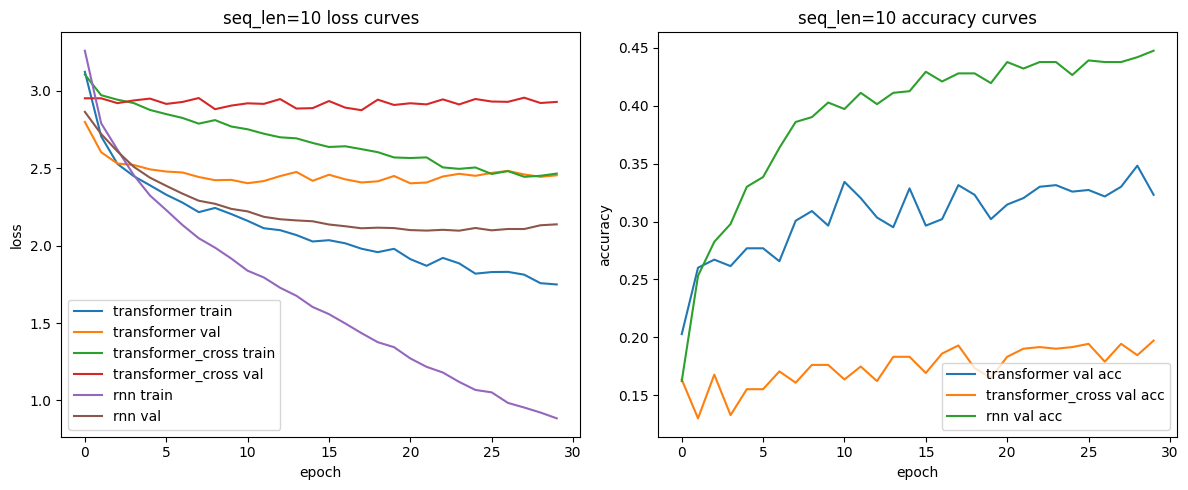

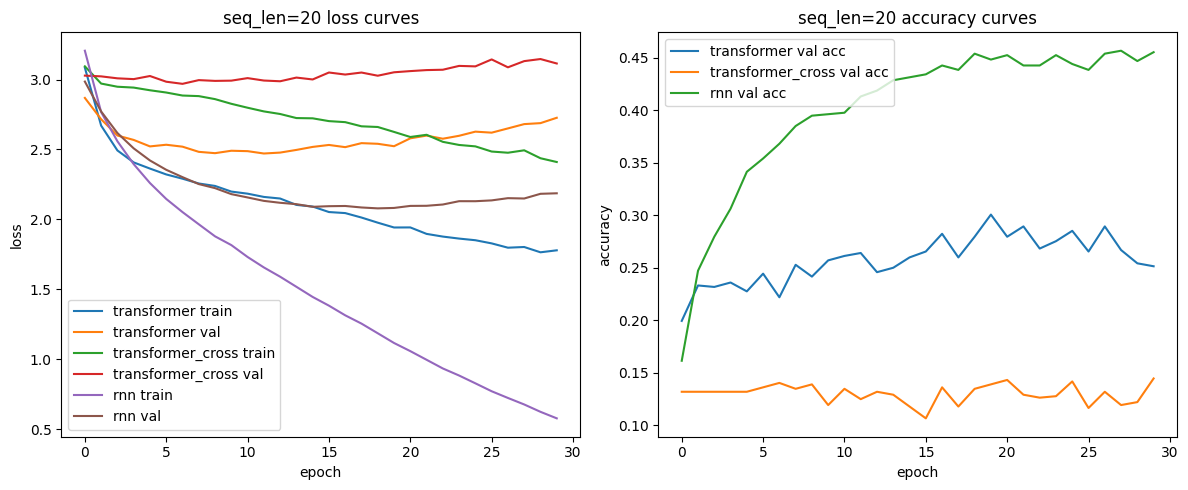

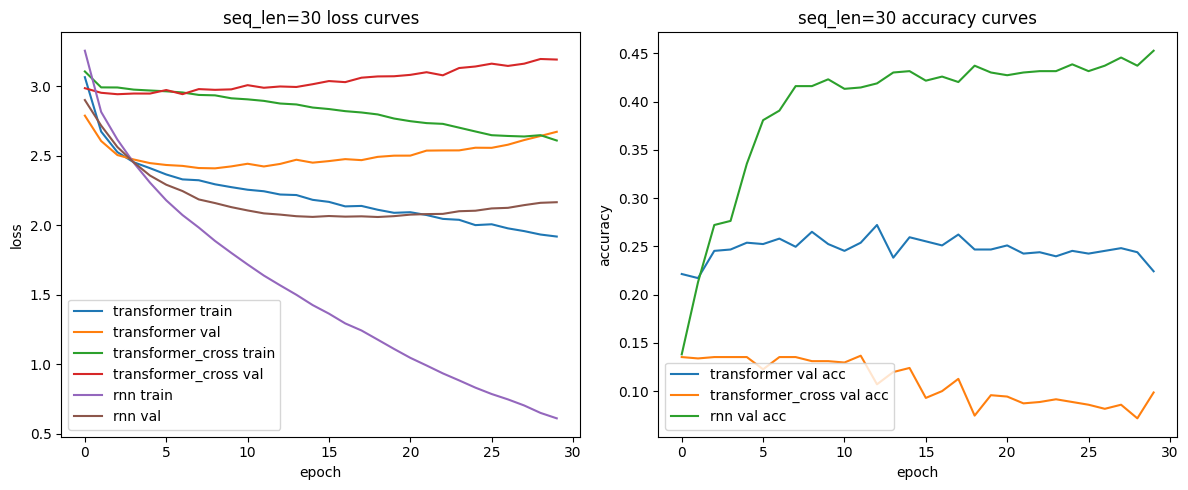

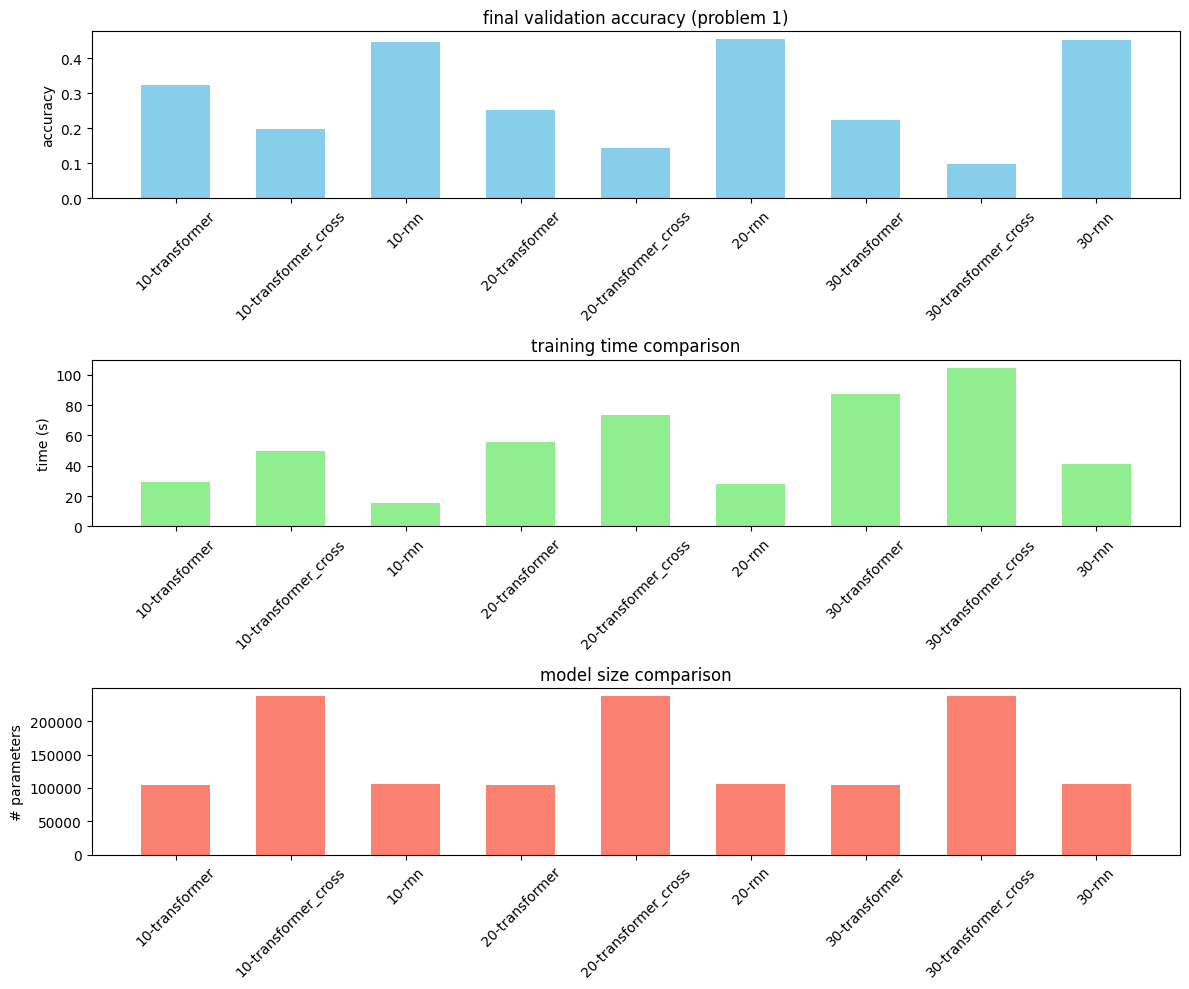

In [3]:
#p1 pt2 hopefully
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

# =====================
# Data Preparation
# =====================
def preprocess_text(text, lowercase=True):
    if lowercase:
        text = text.lower()
    return text

def create_datasets(text, seq_length):
    chars = sorted(list(set(text)))
    char_to_int = {ch: i for i, ch in enumerate(chars)}
    int_to_char = {i: ch for i, ch in enumerate(chars)}
    vocab_size = len(chars)

    encoded = np.array([char_to_int[ch] for ch in text])

    sequences = []
    targets = []
    for i in range(len(encoded) - seq_length):
        sequences.append(encoded[i:i+seq_length])
        targets.append(encoded[i+seq_length])

    # convert lists to numpy arrays
    X = torch.tensor(np.array(sequences), dtype=torch.long)
    y = torch.tensor(np.array(targets), dtype=torch.long)

    return X, y, vocab_size, char_to_int, int_to_char

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# =====================
# Model Definitions
# =====================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            # handle odd dimension
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerPredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, nhead=4, dim_feedforward=256, num_layers=2, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x) * np.sqrt(self.embed.embedding_dim)
        x = self.pos_encoder(x)
        output = self.transformer_encoder(x)
        return self.fc(output[:, -1, :])

class TransformerWithCrossAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, nhead=4, dim_feedforward=256, num_layers=2, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout=dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.query_embed = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.embed(x) * np.sqrt(self.embed.embedding_dim)
        x = self.pos_encoder(x)

        memory = self.encoder(x)
        query = self.query_embed.expand(batch_size, -1, -1)
        dec_out = self.decoder(query, memory)
        return self.fc(dec_out.squeeze(1))

class RNNPredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# =====================
# Training Function
# =====================
def train_model(model, train_loader, val_loader, epochs=30, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'time': 0,
        'params': 0
    }

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(X_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                out = model(X_val)
                loss = criterion(out, y_val)
                val_running_loss += loss.item() * X_val.size(0)
                preds = out.argmax(dim=1)
                correct += (preds == y_val).sum().item()
                total += y_val.size(0)

        avg_val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = correct / total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f"epoch {epoch+1}/{epochs} - train loss: {avg_train_loss:.4f} | val loss: {avg_val_loss:.4f} | val acc: {val_acc:.4f}")

    history['time'] = time.time() - start_time
    history['params'] = sum(p.numel() for p in model.parameters())
    return history

# =====================
# Analysis / Plotting
# =====================
def plot_training_curves(all_results, seq_lengths, model_names):
    """
    Plots training loss and validation accuracy for each model and seq_length.
    all_results is a list of dicts with keys: model, seq_len, train_loss, val_loss, val_acc
    """
    # separate results by seq_len
    for seq_len in seq_lengths:
        # filter results for this seq_len
        seq_len_results = [r for r in all_results if r['seq_len'] == seq_len]

        # set up plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # plot train loss and val loss in the left subplot
        for model_name in model_names:
            # get the corresponding result
            res = next((r for r in seq_len_results if r['model'] == model_name), None)
            if res is not None:
                axes[0].plot(res['train_loss'], label=f"{model_name} train")
                axes[0].plot(res['val_loss'], label=f"{model_name} val")

        axes[0].set_title(f"seq_len={seq_len} loss curves")
        axes[0].set_xlabel("epoch")
        axes[0].set_ylabel("loss")
        axes[0].legend()

        # plot val accuracy in the right subplot
        for model_name in model_names:
            res = next((r for r in seq_len_results if r['model'] == model_name), None)
            if res is not None:
                axes[1].plot(res['val_acc'], label=f"{model_name} val acc")

        axes[1].set_title(f"seq_len={seq_len} accuracy curves")
        axes[1].set_xlabel("epoch")
        axes[1].set_ylabel("accuracy")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

def plot_final_comparisons(all_results, seq_lengths, model_names):
    """
    Creates bar plots for final validation accuracy, training time, and parameter count
    across different models and sequence lengths.
    """
    # prepare data
    # we'll store final accuracy, time, params in dict keyed by (seq_len, model)
    final_acc = {}
    final_time = {}
    final_params = {}
    for seq_len in seq_lengths:
        for model_name in model_names:
            # find the corresponding result
            res = next((r for r in all_results if r['seq_len'] == seq_len and r['model'] == model_name), None)
            if res is not None:
                key = (seq_len, model_name)
                final_acc[key] = res['val_acc'][-1]  # last epoch val acc
                final_time[key] = res['time']
                final_params[key] = res['params']

    # create bar plots
    # 1) final validation accuracy
    plt.figure(figsize=(12, 10))

    plt.subplot(3, 1, 1)
    index = np.arange(len(seq_lengths) * len(model_names))
    bar_width = 0.6
    acc_vals = [final_acc[(s, m)] for s in seq_lengths for m in model_names]
    plt.bar(index, acc_vals, bar_width, color='skyblue')
    plt.xticks(index, [f"{s}-{m}" for s in seq_lengths for m in model_names], rotation=45)
    plt.ylabel("accuracy")
    plt.title("final validation accuracy (problem 1)")
    plt.tight_layout()

    # 2) training time
    plt.subplot(3, 1, 2)
    time_vals = [final_time[(s, m)] for s in seq_lengths for m in model_names]
    plt.bar(index, time_vals, bar_width, color='lightgreen')
    plt.xticks(index, [f"{s}-{m}" for s in seq_lengths for m in model_names], rotation=45)
    plt.ylabel("time (s)")
    plt.title("training time comparison")
    plt.tight_layout()

    # 3) parameter count
    plt.subplot(3, 1, 3)
    param_vals = [final_params[(s, m)] for s in seq_lengths for m in model_names]
    plt.bar(index, param_vals, bar_width, color='salmon')
    plt.xticks(index, [f"{s}-{m}" for s in seq_lengths for m in model_names], rotation=45)
    plt.ylabel("# parameters")
    plt.title("model size comparison")
    plt.tight_layout()

    plt.show()

# =====================
# Main for Problem 1
# =====================
if __name__ == "__main__":
    # problem 1 text
    text_data = """Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.

At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.

One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.

Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time.

Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants.

In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology."""

    text_data = preprocess_text(text_data)
    seq_lengths = [10, 20, 30]
    model_types = {
        'transformer': TransformerPredictor,
        'transformer_cross': TransformerWithCrossAttention,
        'rnn': RNNPredictor
    }

    all_results = []

    for seq_len in seq_lengths:
        print(f"\n=== sequence length: {seq_len} ===")
        X, y, vocab_size, _, _ = create_datasets(text_data, seq_len)
        dataset = TextDataset(X, y)

        # split train/val
        train_size = int(0.7 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        for model_name, model_class in model_types.items():
            print(f"\ntraining {model_name}, seq_len={seq_len}")
            if model_name == 'rnn':
                model = model_class(vocab_size=vocab_size, embed_dim=64, hidden_dim=128, num_layers=1, dropout=0.1).to(device)
            else:
                model = model_class(vocab_size=vocab_size, embed_dim=64, nhead=4, dim_feedforward=256, num_layers=2, dropout=0.1).to(device)

            history = train_model(model, train_loader, val_loader, epochs=30, lr=0.001)
            history['model'] = model_name
            history['seq_len'] = seq_len
            all_results.append(history)
            print(f"final val acc: {history['val_acc'][-1]:.4f}, time: {history['time']:.2f}s, params: {history['params']}")

    # plot training curves (loss & acc) for each seq_length
    plot_training_curves(all_results, seq_lengths, model_names=['transformer','transformer_cross','rnn'])

    # plot final comparisons in bar charts
    plot_final_comparisons(all_results, seq_lengths, model_names=['transformer','transformer_cross','rnn'])


Using device: cuda

Sequence Length: 20


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Transformer: 281665 params, 1.07 MB
RNN: 49729 params, 0.19 MB

Training Transformer Model...


Transformer Epoch 1/10: 100%|██████████| 6972/6972 [00:56<00:00, 123.26it/s]


Transformer - Epoch 1: Train Loss: 2.4089, Val Acc: 32.91%, Time: 60.57s


Transformer Epoch 2/10: 100%|██████████| 6972/6972 [00:54<00:00, 128.88it/s]


Transformer - Epoch 2: Train Loss: 2.2544, Val Acc: 38.03%, Time: 118.19s


Transformer Epoch 3/10: 100%|██████████| 6972/6972 [00:54<00:00, 128.56it/s]


Transformer - Epoch 3: Train Loss: 2.1354, Val Acc: 41.03%, Time: 175.97s


Transformer Epoch 4/10: 100%|██████████| 6972/6972 [00:53<00:00, 130.36it/s]


Transformer - Epoch 4: Train Loss: 2.0230, Val Acc: 44.05%, Time: 233.17s


Transformer Epoch 5/10: 100%|██████████| 6972/6972 [00:56<00:00, 122.35it/s]


Transformer - Epoch 5: Train Loss: 1.9426, Val Acc: 45.87%, Time: 293.94s


Transformer Epoch 6/10: 100%|██████████| 6972/6972 [00:53<00:00, 129.57it/s]


Transformer - Epoch 6: Train Loss: 1.8526, Val Acc: 47.80%, Time: 351.89s


Transformer Epoch 7/10: 100%|██████████| 6972/6972 [00:53<00:00, 129.39it/s]


Transformer - Epoch 7: Train Loss: 1.8242, Val Acc: 48.37%, Time: 409.26s


Transformer Epoch 8/10: 100%|██████████| 6972/6972 [00:53<00:00, 129.55it/s]


Transformer - Epoch 8: Train Loss: 1.8061, Val Acc: 48.77%, Time: 466.63s


Transformer Epoch 9/10: 100%|██████████| 6972/6972 [00:54<00:00, 127.66it/s]


Transformer - Epoch 9: Train Loss: 1.7908, Val Acc: 49.26%, Time: 524.78s


Transformer Epoch 10/10: 100%|██████████| 6972/6972 [00:53<00:00, 130.02it/s]


Transformer - Epoch 10: Train Loss: 1.7764, Val Acc: 49.45%, Time: 582.61s

Training RNN Model...


RNN Epoch 1/10: 100%|██████████| 6972/6972 [00:24<00:00, 282.92it/s]


RNN - Epoch 1: Train Loss: 1.8732, Val Acc: 49.26%, Time: 27.33s


RNN Epoch 2/10: 100%|██████████| 6972/6972 [00:24<00:00, 279.56it/s]


RNN - Epoch 2: Train Loss: 1.6593, Val Acc: 51.31%, Time: 54.96s


RNN Epoch 3/10: 100%|██████████| 6972/6972 [00:24<00:00, 285.77it/s]


RNN - Epoch 3: Train Loss: 1.6085, Val Acc: 51.97%, Time: 82.63s


RNN Epoch 4/10: 100%|██████████| 6972/6972 [00:24<00:00, 285.93it/s]


RNN - Epoch 4: Train Loss: 1.5810, Val Acc: 52.37%, Time: 109.70s


RNN Epoch 5/10: 100%|██████████| 6972/6972 [00:24<00:00, 285.44it/s]


RNN - Epoch 5: Train Loss: 1.5639, Val Acc: 52.59%, Time: 136.81s


RNN Epoch 6/10: 100%|██████████| 6972/6972 [00:24<00:00, 286.49it/s]


RNN - Epoch 6: Train Loss: 1.5245, Val Acc: 53.52%, Time: 163.85s


RNN Epoch 7/10: 100%|██████████| 6972/6972 [00:25<00:00, 275.64it/s]


RNN - Epoch 7: Train Loss: 1.5154, Val Acc: 53.71%, Time: 192.43s


RNN Epoch 8/10: 100%|██████████| 6972/6972 [00:24<00:00, 285.64it/s]


RNN - Epoch 8: Train Loss: 1.5097, Val Acc: 53.87%, Time: 219.51s


RNN Epoch 9/10: 100%|██████████| 6972/6972 [00:24<00:00, 286.42it/s]


RNN - Epoch 9: Train Loss: 1.5051, Val Acc: 53.84%, Time: 246.54s


RNN Epoch 10/10: 100%|██████████| 6972/6972 [00:24<00:00, 286.45it/s]


RNN - Epoch 10: Train Loss: 1.5010, Val Acc: 54.00%, Time: 273.59s

Transformer generated text:
ROMEO: :
Si:
Th  feee the shall the shall the shall the shall the shall the shall the shall the shall the s

RNN generated text:
ROMEO: he shall be the consent the consent the consent the consent the consent the consent the consent the 
Plotting curves for sequence length 20 (Transformer)


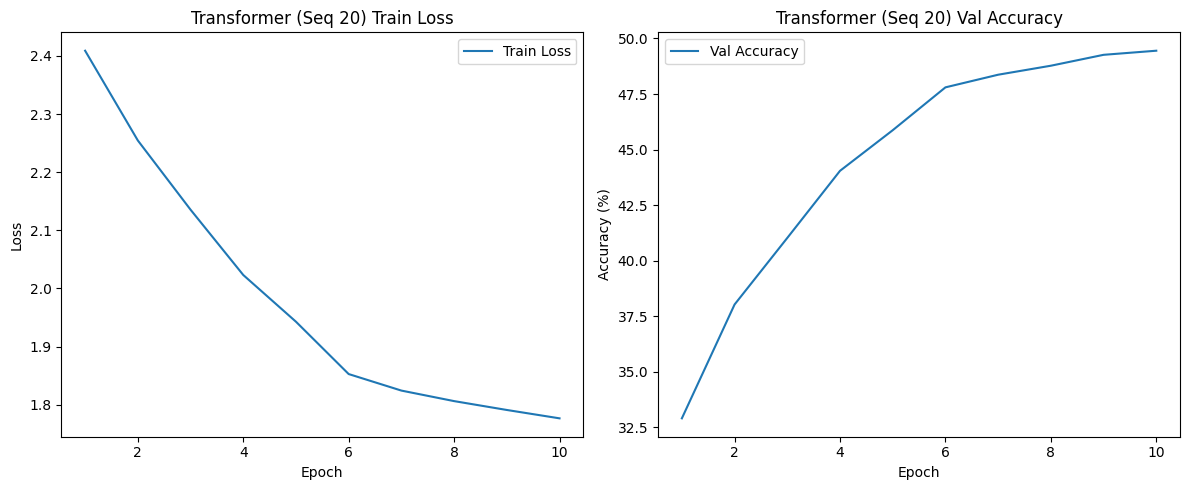

Plotting curves for sequence length 20 (RNN)


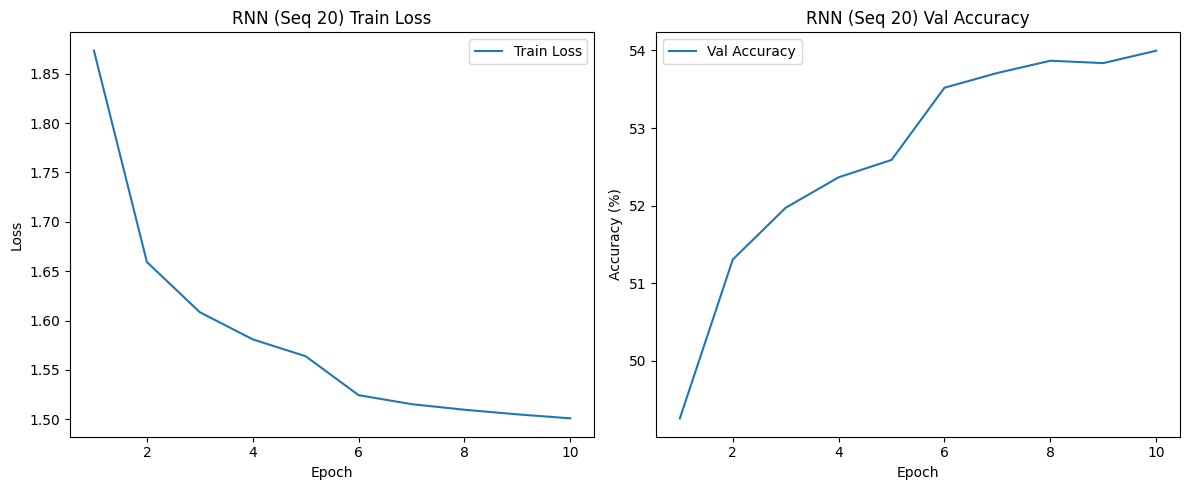


Sequence Length: 30


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Transformer: 281665 params, 1.07 MB
RNN: 49729 params, 0.19 MB

Training Transformer Model...


Transformer Epoch 1/10: 100%|██████████| 6972/6972 [00:57<00:00, 120.35it/s]


Transformer - Epoch 1: Train Loss: 2.4362, Val Acc: 30.34%, Time: 62.41s


Transformer Epoch 2/10: 100%|██████████| 6972/6972 [00:56<00:00, 123.12it/s]


Transformer - Epoch 2: Train Loss: 2.3403, Val Acc: 34.00%, Time: 123.53s


Transformer Epoch 3/10: 100%|██████████| 6972/6972 [00:57<00:00, 121.51it/s]


Transformer - Epoch 3: Train Loss: 2.2054, Val Acc: 39.98%, Time: 185.38s


Transformer Epoch 4/10: 100%|██████████| 6972/6972 [00:56<00:00, 122.99it/s]


Transformer - Epoch 4: Train Loss: 2.0670, Val Acc: 42.95%, Time: 246.56s


Transformer Epoch 5/10: 100%|██████████| 6972/6972 [00:56<00:00, 122.63it/s]


Transformer - Epoch 5: Train Loss: 1.9765, Val Acc: 45.03%, Time: 307.81s


Transformer Epoch 6/10: 100%|██████████| 6972/6972 [00:55<00:00, 125.07it/s]


Transformer - Epoch 6: Train Loss: 1.8831, Val Acc: 46.88%, Time: 367.96s


Transformer Epoch 7/10: 100%|██████████| 6972/6972 [00:57<00:00, 121.70it/s]


Transformer - Epoch 7: Train Loss: 1.8497, Val Acc: 47.67%, Time: 429.51s


Transformer Epoch 8/10: 100%|██████████| 6972/6972 [00:57<00:00, 121.23it/s]


Transformer - Epoch 8: Train Loss: 1.8284, Val Acc: 48.20%, Time: 491.07s


Transformer Epoch 9/10: 100%|██████████| 6972/6972 [00:57<00:00, 121.17it/s]


Transformer - Epoch 9: Train Loss: 1.8103, Val Acc: 48.63%, Time: 552.64s


Transformer Epoch 10/10: 100%|██████████| 6972/6972 [00:56<00:00, 123.06it/s]


Transformer - Epoch 10: Train Loss: 1.7954, Val Acc: 49.01%, Time: 613.32s

Training RNN Model...


RNN Epoch 1/10: 100%|██████████| 6972/6972 [00:26<00:00, 267.26it/s]


RNN - Epoch 1: Train Loss: 1.8722, Val Acc: 49.01%, Time: 29.05s


RNN Epoch 2/10: 100%|██████████| 6972/6972 [00:26<00:00, 258.32it/s]


RNN - Epoch 2: Train Loss: 1.6578, Val Acc: 51.01%, Time: 58.89s


RNN Epoch 3/10: 100%|██████████| 6972/6972 [00:26<00:00, 266.52it/s]


RNN - Epoch 3: Train Loss: 1.6068, Val Acc: 52.09%, Time: 87.88s


RNN Epoch 4/10: 100%|██████████| 6972/6972 [00:26<00:00, 264.23it/s]


RNN - Epoch 4: Train Loss: 1.5809, Val Acc: 52.36%, Time: 117.48s


RNN Epoch 5/10: 100%|██████████| 6972/6972 [00:26<00:00, 266.18it/s]


RNN - Epoch 5: Train Loss: 1.5645, Val Acc: 52.74%, Time: 146.56s


RNN Epoch 6/10: 100%|██████████| 6972/6972 [00:25<00:00, 269.33it/s]


RNN - Epoch 6: Train Loss: 1.5258, Val Acc: 53.51%, Time: 176.20s


RNN Epoch 7/10: 100%|██████████| 6972/6972 [00:26<00:00, 263.21it/s]


RNN - Epoch 7: Train Loss: 1.5171, Val Acc: 53.62%, Time: 205.53s


RNN Epoch 8/10: 100%|██████████| 6972/6972 [00:25<00:00, 268.19it/s]


RNN - Epoch 8: Train Loss: 1.5115, Val Acc: 53.78%, Time: 234.41s


RNN Epoch 9/10: 100%|██████████| 6972/6972 [00:26<00:00, 266.22it/s]


RNN - Epoch 9: Train Loss: 1.5070, Val Acc: 53.83%, Time: 263.92s


RNN Epoch 10/10: 100%|██████████| 6972/6972 [00:25<00:00, 268.54it/s]


RNN - Epoch 10: Train Loss: 1.5029, Val Acc: 53.79%, Time: 292.76s

Transformer generated text:
ROMEO: , ,               
TER: the shall the shall the shall the shall the shall the shall the shall the sh

RNN generated text:
ROMEO: I have so say the seem that so say the seem that so say the seem that so say the seem that so say th
Plotting curves for sequence length 30 (Transformer)


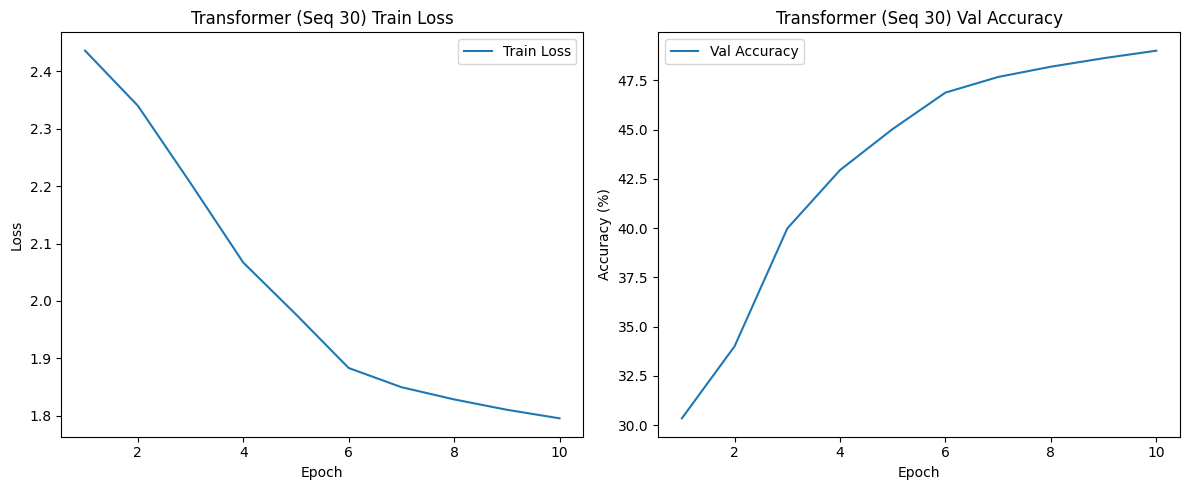

Plotting curves for sequence length 30 (RNN)


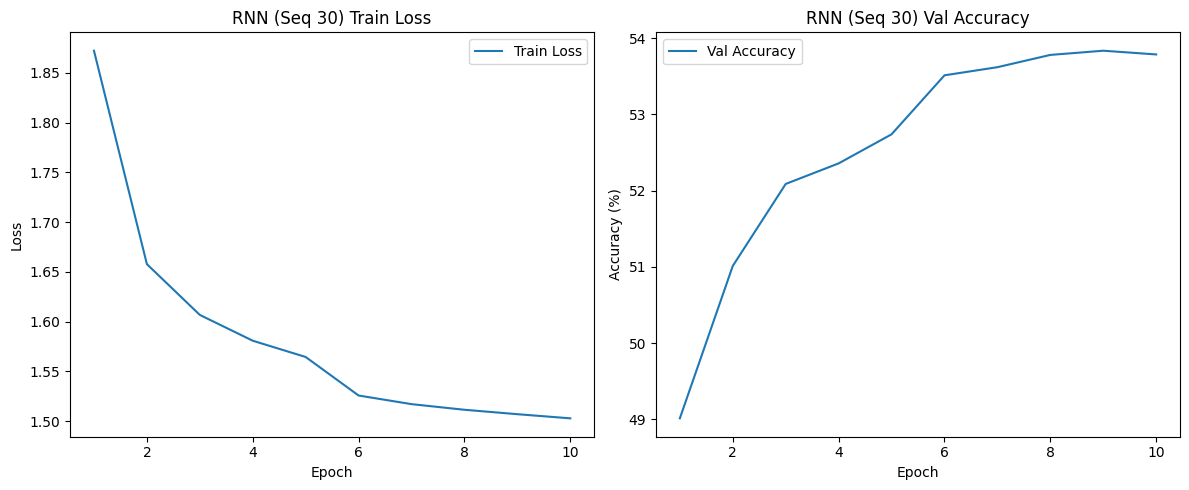


Hyperparameter Exploration on Sequence Length: 30

Config: L1_H2_D128
Layers: 1, Heads: 2, Hidden size: 128
Model complexity: 149185 params, 0.57 MB


L1_H2_D128 Epoch 1/5: 100%|██████████| 6972/6972 [00:40<00:00, 172.65it/s]


L1_H2_D128 - Epoch 1: Train Loss: 2.5158, Val Acc: 27.10%, Time: 43.44s


L1_H2_D128 Epoch 2/5: 100%|██████████| 6972/6972 [00:38<00:00, 179.92it/s]


L1_H2_D128 - Epoch 2: Train Loss: 2.4721, Val Acc: 27.47%, Time: 85.24s


L1_H2_D128 Epoch 3/5: 100%|██████████| 6972/6972 [00:39<00:00, 178.50it/s]


L1_H2_D128 - Epoch 3: Train Loss: 2.4608, Val Acc: 27.49%, Time: 127.55s


L1_H2_D128 Epoch 4/5: 100%|██████████| 6972/6972 [00:39<00:00, 177.54it/s]


L1_H2_D128 - Epoch 4: Train Loss: 2.4553, Val Acc: 27.77%, Time: 169.88s


L1_H2_D128 Epoch 5/5: 100%|██████████| 6972/6972 [00:39<00:00, 178.16it/s]


L1_H2_D128 - Epoch 5: Train Loss: 2.4517, Val Acc: 27.82%, Time: 212.38s
Average inference time: 0.0132s


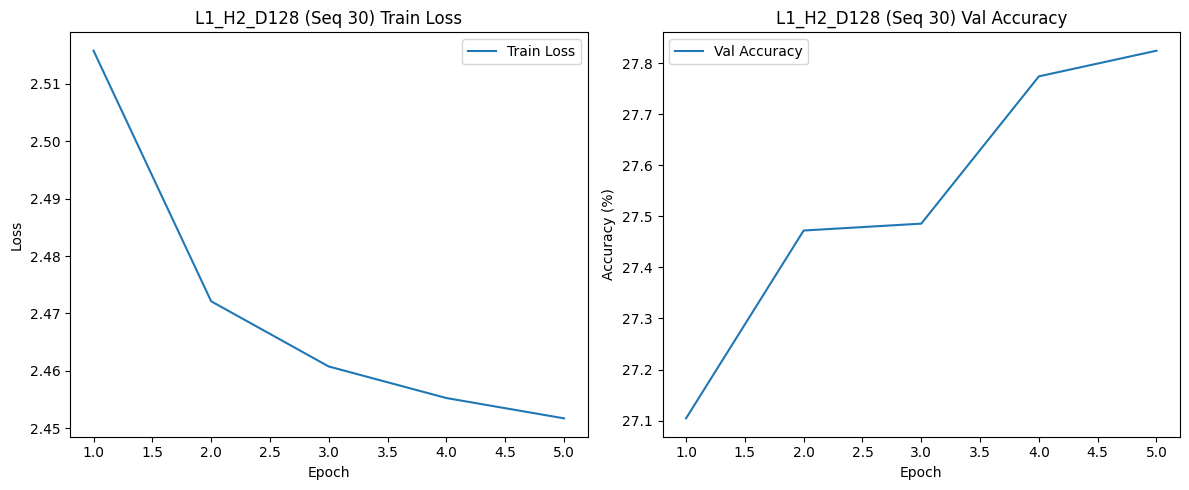


Config: L1_H4_D128
Layers: 1, Heads: 4, Hidden size: 128
Model complexity: 149185 params, 0.57 MB


L1_H4_D128 Epoch 1/5: 100%|██████████| 6972/6972 [00:38<00:00, 179.51it/s]


L1_H4_D128 - Epoch 1: Train Loss: 2.5100, Val Acc: 27.24%, Time: 41.93s


L1_H4_D128 Epoch 2/5: 100%|██████████| 6972/6972 [00:40<00:00, 173.88it/s]


L1_H4_D128 - Epoch 2: Train Loss: 2.4682, Val Acc: 27.62%, Time: 85.12s


L1_H4_D128 Epoch 3/5: 100%|██████████| 6972/6972 [00:38<00:00, 179.19it/s]


L1_H4_D128 - Epoch 3: Train Loss: 2.4588, Val Acc: 27.95%, Time: 127.18s


L1_H4_D128 Epoch 4/5: 100%|██████████| 6972/6972 [00:39<00:00, 176.90it/s]


L1_H4_D128 - Epoch 4: Train Loss: 2.4508, Val Acc: 28.20%, Time: 169.69s


L1_H4_D128 Epoch 5/5: 100%|██████████| 6972/6972 [00:39<00:00, 176.83it/s]


L1_H4_D128 - Epoch 5: Train Loss: 2.4418, Val Acc: 28.18%, Time: 212.25s
Average inference time: 0.0143s


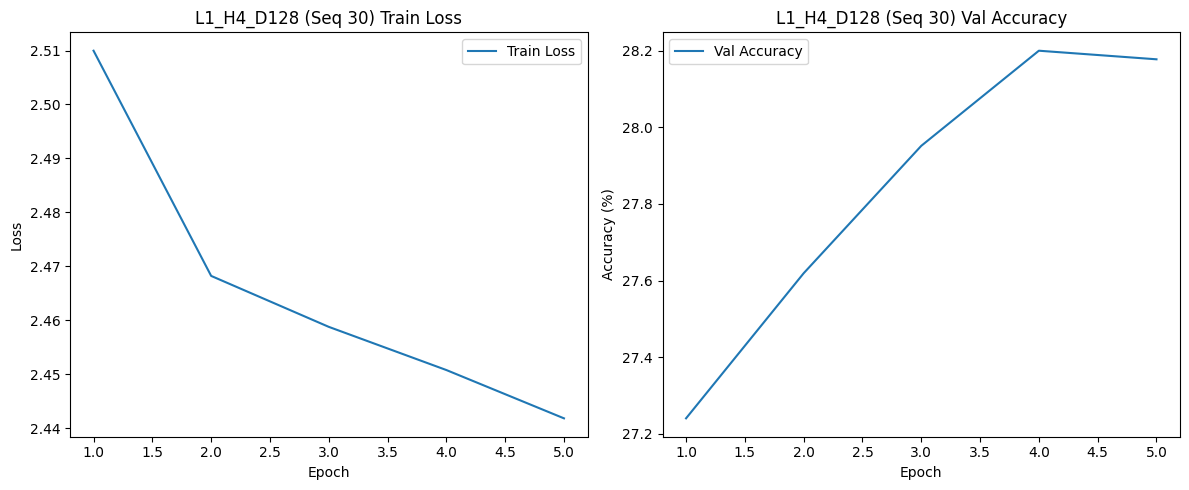


Config: L2_H2_D128
Layers: 2, Heads: 2, Hidden size: 128
Model complexity: 281665 params, 1.07 MB


L2_H2_D128 Epoch 1/5: 100%|██████████| 6972/6972 [00:57<00:00, 122.03it/s]


L2_H2_D128 - Epoch 1: Train Loss: 2.4493, Val Acc: 29.87%, Time: 61.16s


L2_H2_D128 Epoch 2/5: 100%|██████████| 6972/6972 [00:58<00:00, 119.86it/s]


L2_H2_D128 - Epoch 2: Train Loss: 2.3629, Val Acc: 33.88%, Time: 123.78s


L2_H2_D128 Epoch 3/5: 100%|██████████| 6972/6972 [00:56<00:00, 123.42it/s]


L2_H2_D128 - Epoch 3: Train Loss: 2.2270, Val Acc: 39.46%, Time: 184.67s


L2_H2_D128 Epoch 4/5: 100%|██████████| 6972/6972 [00:56<00:00, 122.73it/s]


L2_H2_D128 - Epoch 4: Train Loss: 2.1028, Val Acc: 42.27%, Time: 245.85s


L2_H2_D128 Epoch 5/5: 100%|██████████| 6972/6972 [00:55<00:00, 124.84it/s]


L2_H2_D128 - Epoch 5: Train Loss: 2.0179, Val Acc: 44.34%, Time: 306.08s
Average inference time: 0.0201s


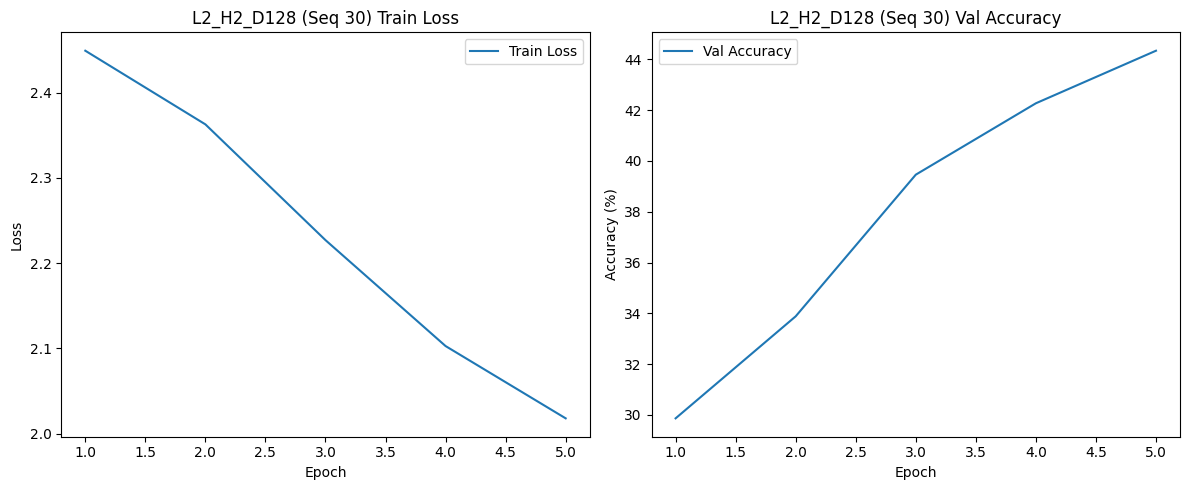


Config: L2_H4_D128
Layers: 2, Heads: 4, Hidden size: 128
Model complexity: 281665 params, 1.07 MB


L2_H4_D128 Epoch 1/5: 100%|██████████| 6972/6972 [00:57<00:00, 121.99it/s]


L2_H4_D128 - Epoch 1: Train Loss: 2.4377, Val Acc: 30.36%, Time: 61.58s


L2_H4_D128 Epoch 2/5: 100%|██████████| 6972/6972 [00:56<00:00, 122.87it/s]


L2_H4_D128 - Epoch 2: Train Loss: 2.3439, Val Acc: 33.98%, Time: 122.74s


L2_H4_D128 Epoch 3/5: 100%|██████████| 6972/6972 [00:57<00:00, 120.65it/s]


L2_H4_D128 - Epoch 3: Train Loss: 2.2368, Val Acc: 38.30%, Time: 184.65s


L2_H4_D128 Epoch 4/5: 100%|██████████| 6972/6972 [00:57<00:00, 121.55it/s]


L2_H4_D128 - Epoch 4: Train Loss: 2.1241, Val Acc: 41.95%, Time: 246.04s


L2_H4_D128 Epoch 5/5: 100%|██████████| 6972/6972 [00:58<00:00, 119.62it/s]


L2_H4_D128 - Epoch 5: Train Loss: 2.0154, Val Acc: 44.77%, Time: 308.37s
Average inference time: 0.0205s


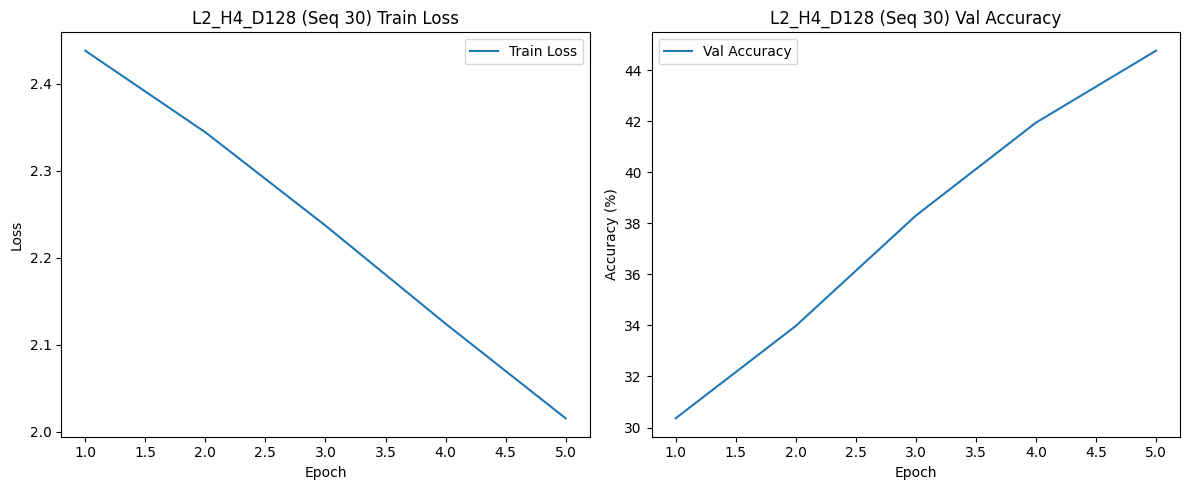


Config: L4_H2_D128
Layers: 4, Heads: 2, Hidden size: 128
Model complexity: 546625 params, 2.09 MB


L4_H2_D128 Epoch 1/5: 100%|██████████| 6972/6972 [01:35<00:00, 73.04it/s]


L4_H2_D128 - Epoch 1: Train Loss: 2.4217, Val Acc: 31.46%, Time: 101.43s


L4_H2_D128 Epoch 2/5: 100%|██████████| 6972/6972 [01:36<00:00, 72.44it/s]


L4_H2_D128 - Epoch 2: Train Loss: 2.3142, Val Acc: 35.92%, Time: 203.99s


L4_H2_D128 Epoch 3/5: 100%|██████████| 6972/6972 [01:35<00:00, 73.18it/s]


L4_H2_D128 - Epoch 3: Train Loss: 2.1647, Val Acc: 41.14%, Time: 305.41s


L4_H2_D128 Epoch 4/5: 100%|██████████| 6972/6972 [01:35<00:00, 73.24it/s]


L4_H2_D128 - Epoch 4: Train Loss: 2.0273, Val Acc: 44.08%, Time: 406.56s


L4_H2_D128 Epoch 5/5: 100%|██████████| 6972/6972 [01:34<00:00, 73.40it/s]


L4_H2_D128 - Epoch 5: Train Loss: 1.9271, Val Acc: 46.24%, Time: 507.82s
Average inference time: 0.0326s


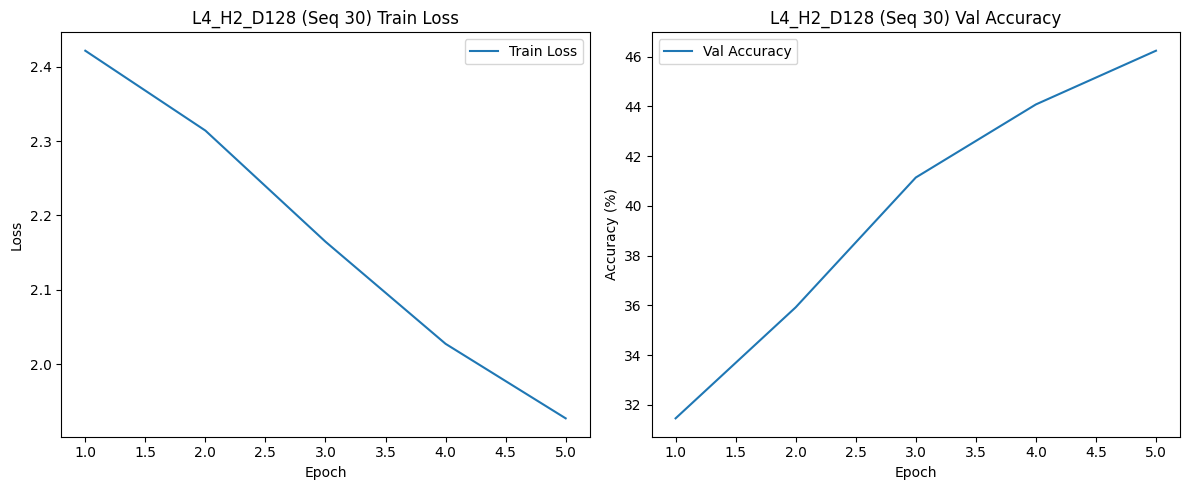


Config: L4_H4_D128
Layers: 4, Heads: 4, Hidden size: 128
Model complexity: 546625 params, 2.09 MB


L4_H4_D128 Epoch 1/5: 100%|██████████| 6972/6972 [01:41<00:00, 69.01it/s]


L4_H4_D128 - Epoch 1: Train Loss: 2.4121, Val Acc: 31.42%, Time: 107.50s


L4_H4_D128 Epoch 2/5: 100%|██████████| 6972/6972 [01:42<00:00, 67.82it/s]


L4_H4_D128 - Epoch 2: Train Loss: 2.3025, Val Acc: 36.47%, Time: 216.49s


L4_H4_D128 Epoch 3/5: 100%|██████████| 6972/6972 [01:39<00:00, 69.93it/s]


L4_H4_D128 - Epoch 3: Train Loss: 2.1390, Val Acc: 42.08%, Time: 322.50s


L4_H4_D128 Epoch 4/5: 100%|██████████| 6972/6972 [02:03<00:00, 56.58it/s]


L4_H4_D128 - Epoch 4: Train Loss: 1.9859, Val Acc: 45.20%, Time: 452.48s


L4_H4_D128 Epoch 5/5: 100%|██████████| 6972/6972 [02:04<00:00, 55.94it/s]


L4_H4_D128 - Epoch 5: Train Loss: 1.8820, Val Acc: 47.28%, Time: 584.35s
Average inference time: 0.0325s


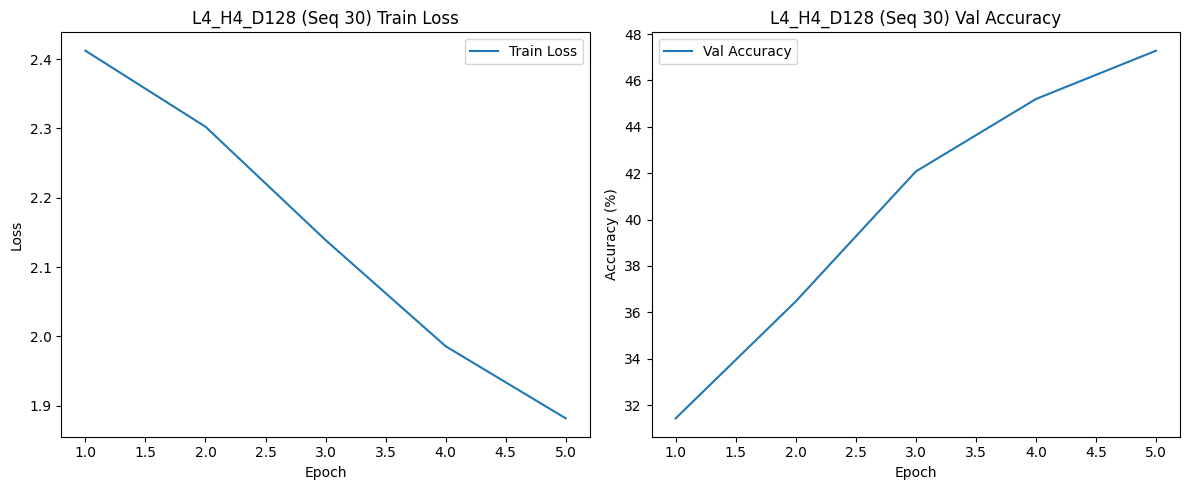


Sequence Length: 50
Transformer: 281665 params, 1.07 MB
RNN: 49729 params, 0.19 MB

Training Transformer Model...


Transformer Epoch 1/10: 100%|██████████| 6971/6971 [01:15<00:00, 92.64it/s]


Transformer - Epoch 1: Train Loss: 2.4727, Val Acc: 29.18%, Time: 80.91s


Transformer Epoch 2/10: 100%|██████████| 6971/6971 [01:14<00:00, 93.80it/s]


Transformer - Epoch 2: Train Loss: 2.3888, Val Acc: 31.04%, Time: 160.60s


Transformer Epoch 3/10: 100%|██████████| 6971/6971 [01:15<00:00, 92.62it/s]


Transformer - Epoch 3: Train Loss: 2.3293, Val Acc: 36.09%, Time: 241.55s


Transformer Epoch 4/10: 100%|██████████| 6971/6971 [01:15<00:00, 92.91it/s]


Transformer - Epoch 4: Train Loss: 2.1721, Val Acc: 41.43%, Time: 321.98s


Transformer Epoch 5/10: 100%|██████████| 6971/6971 [01:15<00:00, 92.88it/s]


Transformer - Epoch 5: Train Loss: 2.0371, Val Acc: 43.82%, Time: 402.60s


Transformer Epoch 6/10:  44%|████▎     | 3033/6971 [00:32<00:49, 80.16it/s]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random, time, math, requests
from tqdm import tqdm

# ----- Reproducibility and Device -----
random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----- Download Tiny Shakespeare Dataset -----
def download_shakespeare():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    response = requests.get(url)
    return response.text

text = download_shakespeare()

# ----- Dataset Preparation -----
def create_dataset(text, sequence_length):
    # Build vocabulary from characters
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    char_to_int = {ch: i for i, ch in enumerate(chars)}
    int_to_char = {i: ch for i, ch in enumerate(chars)}
    # Encode text
    encoded = np.array([char_to_int[ch] for ch in text])
    # Create sequences using sliding window
    sequences = []
    targets = []
    for i in range(len(encoded) - sequence_length):
        sequences.append(encoded[i:i+sequence_length])
        targets.append(encoded[i+sequence_length])
    # Convert to tensors (convert list to np.array first to speed up)
    sequences = torch.tensor(np.array(sequences), dtype=torch.long)
    targets = torch.tensor(np.array(targets), dtype=torch.long)
    return sequences, targets, vocab_size, char_to_int, int_to_char

class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# ----- Positional Encoding Module -----
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(pos * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1), :])

# ----- Transformer Model for Language Modeling -----
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model
    def forward(self, x):
        # x: [batch, seq_len]
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_enc(x)
        out = self.encoder(x)
        # Use last token output for prediction
        out = self.fc_out(out[:, -1, :])
        return out

# ----- RNN Model for Language Modeling -----
class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x):
        # x: [batch, seq_len]
        batch_size = x.size(0)
        hidden = torch.zeros(1, batch_size, self.rnn.hidden_size).to(x.device)
        x = self.embedding(x)
        out, _ = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out

# ----- Training Function -----
def train_model(model, train_loader, val_loader, epochs, lr, device, model_name="Model"):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    history = {'train_losses': [], 'val_accs': [], 'epoch_times': []}
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in tqdm(train_loader, desc=f"{model_name} Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            total_loss += loss.item() * inputs.size(0)
        avg_train_loss = total_loss / len(train_loader.dataset)
        history['train_losses'].append(avg_train_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        val_acc = 100 * correct / total
        history['val_accs'].append(val_acc)

        epoch_time = time.time() - start_time
        history['epoch_times'].append(epoch_time)

        scheduler.step()
        print(f"{model_name} - Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

    history['total_time'] = time.time() - start_time
    return history

# ----- Model Complexity Calculation -----
def calculate_model_complexity(model):
    total_params = sum(p.numel() for p in model.parameters())
    model_size_mb = total_params * 4 / (1024*1024)
    return {'params': total_params, 'size_mb': model_size_mb}

# ----- Generate Text (for qualitative evaluation) -----
def generate_text(model, seed_text, char_to_int, int_to_char, seq_length, num_chars=100):
    model.eval()
    current_seq = torch.tensor([[char_to_int[ch] for ch in seed_text]], dtype=torch.long).to(device)
    generated_text = seed_text
    with torch.no_grad():
        for _ in range(num_chars):
            if current_seq.size(1) > seq_length:
                inp = current_seq[:, -seq_length:]
            else:
                inp = current_seq
            output = model(inp)
            next_idx = output.argmax(dim=1).item()
            generated_text += int_to_char[next_idx]
            next_tensor = torch.tensor([[next_idx]], dtype=torch.long).to(device)
            current_seq = torch.cat([current_seq, next_tensor], dim=1)
    return generated_text

# ----- Plotting Functions -----
def plot_curves(history, title_prefix=""):
    epochs = range(1, len(history['train_losses'])+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_losses'], label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Train Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history['val_accs'], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{title_prefix} Val Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_bar_comparisons(final_metrics, metric_name, ylabel, title):
    configs = list(final_metrics.keys())
    values = [final_metrics[k][metric_name] for k in configs]
    plt.figure(figsize=(10,5))
    plt.bar(configs, values)
    plt.xlabel("Configuration")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ----- Experiments: Sequence Length and Hyperparameter Exploration -----
def run_experiments(sequence_lengths, epochs=10, lr=0.001):
    overall_results = {}
    for seq_len in sequence_lengths:
        print(f"\n{'='*50}\nSequence Length: {seq_len}\n{'='*50}")
        sequences, targets, vocab_size, char_to_int, int_to_char = create_dataset(text, seq_len)
        dataset = CharDataset(sequences, targets)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        batch_size = 128
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Instantiate models
        transformer = TransformerModel(vocab_size, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
        rnn = RNNModel(vocab_size, hidden_size=128, num_layers=1)

        # Calculate model complexities
        transformer_complexity = calculate_model_complexity(transformer)
        rnn_complexity = calculate_model_complexity(rnn)
        print(f"Transformer: {transformer_complexity['params']} params, {transformer_complexity['size_mb']:.2f} MB")
        print(f"RNN: {rnn_complexity['params']} params, {rnn_complexity['size_mb']:.2f} MB")

        # Train models
        print("\nTraining Transformer Model...")
        transformer_optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)
        transformer_scheduler = torch.optim.lr_scheduler.StepLR(transformer_optimizer, step_size=5, gamma=0.5)
        transformer_history = train_model(transformer, train_loader, val_loader, epochs, lr, device, model_name="Transformer")

        print("\nTraining RNN Model...")
        rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
        rnn_scheduler = torch.optim.lr_scheduler.StepLR(rnn_optimizer, step_size=5, gamma=0.5)
        rnn_history = train_model(rnn, train_loader, val_loader, epochs, lr, device, model_name="RNN")

        # Generate sample text for qualitative evaluation
        seed_text = "ROMEO: "
        transformer_generated = generate_text(transformer, seed_text, char_to_int, int_to_char, seq_len, num_chars=100)
        rnn_generated = generate_text(rnn, seed_text, char_to_int, int_to_char, seq_len, num_chars=100)

        print("\nTransformer generated text:")
        print(transformer_generated)
        print("\nRNN generated text:")
        print(rnn_generated)

        overall_results[seq_len] = {
            'transformer': {
                'history': transformer_history,
                'complexity': transformer_complexity,
                'generated_text': transformer_generated
            },
            'rnn': {
                'history': rnn_history,
                'complexity': rnn_complexity,
                'generated_text': rnn_generated
            },
            'vocab_size': vocab_size,
            'char_to_int': char_to_int,
            'int_to_char': int_to_char
        }
        # Plot curves for this sequence length
        print(f"Plotting curves for sequence length {seq_len} (Transformer)")
        plot_curves(transformer_history, title_prefix=f"Transformer (Seq {seq_len})")
        print(f"Plotting curves for sequence length {seq_len} (RNN)")
        plot_curves(rnn_history, title_prefix=f"RNN (Seq {seq_len})")
    return overall_results

def hyperparameter_exploration(seq_length, layers_options, heads_options, d_model_options, epochs=5, lr=0.001):
    print(f"\nHyperparameter Exploration on Sequence Length: {seq_length}")
    sequences, targets, vocab_size, char_to_int, int_to_char = create_dataset(text, seq_length)
    dataset = CharDataset(sequences, targets)
    batch_size = 128
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    exploration_results = {}
    for num_layers in layers_options:
        for nhead in heads_options:
            for d_model in d_model_options:
                config_name = f"L{num_layers}_H{nhead}_D{d_model}"
                print(f"\n{'='*50}\nConfig: {config_name}\nLayers: {num_layers}, Heads: {nhead}, Hidden size: {d_model}\n{'='*50}")
                model = TransformerModel(vocab_size, d_model, nhead, num_layers, dim_feedforward=256, dropout=0.1)
                complexity = calculate_model_complexity(model)
                print(f"Model complexity: {complexity['params']} params, {complexity['size_mb']:.2f} MB")
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
                criterion = nn.CrossEntropyLoss()
                history = train_model(model, train_loader, val_loader, epochs, lr, device, model_name=config_name)
                generated_text = generate_text(model, "ROMEO: ", char_to_int, int_to_char, seq_length, num_chars=100)
                # Measure average inference time over 10 runs
                start_inf = time.time()
                with torch.no_grad():
                    for _ in range(10):
                        _ = generate_text(model, "ROMEO: ", char_to_int, int_to_char, seq_length, num_chars=20)
                inf_time = (time.time() - start_inf) / 10
                print(f"Average inference time: {inf_time:.4f}s")
                exploration_results[config_name] = {
                    'history': history,
                    'complexity': complexity,
                    'generated_text': generated_text,
                    'inference_time': inf_time,
                    'config': {'num_layers': num_layers, 'nhead': nhead, 'd_model': d_model}
                }
                plot_curves(history, title_prefix=f"{config_name} (Seq {seq_length})")
    return exploration_results

# ----- Main Execution for Problem 2 -----
if __name__ == "__main__":
    # Part 1: Sequence Length Comparison (20 and 30)
    seq_lengths = [20, 30]
    results = run_experiments(seq_lengths, epochs=10, lr=0.001)

    # Part 2: Hyperparameter Exploration on sequence length 30
    layers_options = [1, 2, 4]
    heads_options = [2, 4]
    d_model_options = [128]  # fixed hidden size for simplicity
    hyper_results = hyperparameter_exploration(30, layers_options, heads_options, d_model_options, epochs=5, lr=0.001)

    # Part 3: Increase sequence length to 50
    results_50 = run_experiments([50], epochs=10, lr=0.001)

    # Print Summary Table for Part 1 (Sequence Length Comparison)
    print("\n" + "="*50)
    print("Summary of Part 1: Sequence Length Comparison")
    print("="*50)
    for seq_len in seq_lengths:
        tf_res = results[seq_len]['transformer']['history']
        rnn_res = results[seq_len]['rnn']['history']
        print(f"\nSequence Length: {seq_len}")
        print(f"Transformer Final Train Loss: {tf_res['train_losses'][-1]:.4f}")
        print(f"Transformer Final Val Acc: {tf_res['val_accs'][-1]:.2f}%")
        print(f"Transformer Total Time: {tf_res['total_time']:.2f}s")
        print(f"RNN Final Train Loss: {rnn_res['train_losses'][-1]:.4f}")
        print(f"RNN Final Val Acc: {rnn_res['val_accs'][-1]:.2f}%")
        print(f"RNN Total Time: {rnn_res['total_time']:.2f}s")

    # Print Summary Table for Part 2 (Hyperparameter Exploration)
    print("\n" + "="*50)
    print("Summary of Part 2: Hyperparameter Exploration (Seq Length 30)")
    print("="*50)
    for config_name, res in hyper_results.items():
        cfg = res['config']
        print(f"Config: {config_name} (Layers: {cfg['num_layers']}, Heads: {cfg['nhead']}, D_model: {cfg['d_model']})")
        hist = res['history']
        print(f"Final Train Loss: {hist['train_losses'][-1]:.4f}")
        print(f"Final Val Acc: {hist['val_accs'][-1]:.2f}%")
        print(f"Training Time: {hist['total_time']:.2f}s, Inference Time: {res['inference_time']:.4f}s")
        print(f"Model Size: {res['complexity']['params']} params, {res['complexity']['size_mb']:.2f} MB\n")

    # Print Summary for Part 3 (Sequence Length 50)
    print("\n" + "="*50)
    print("Summary of Part 3: Increased Sequence Length (50)")
    print("="*50)
    tf_res_50 = results_50[50]['transformer']['history']
    rnn_res_50 = results_50[50]['rnn']['history']
    print(f"Transformer (Seq 50) Final Train Loss: {tf_res_50['train_losses'][-1]:.4f}")
    print(f"Transformer (Seq 50) Final Val Acc: {tf_res_50['val_accs'][-1]:.2f}%")
    print(f"Transformer (Seq 50) Total Time: {tf_res_50['total_time']:.2f}s")
    print(f"RNN (Seq 50) Final Train Loss: {rnn_res_50['train_losses'][-1]:.4f}")
    print(f"RNN (Seq 50) Final Val Acc: {rnn_res_50['val_accs'][-1]:.2f}%")
    print(f"RNN (Seq 50) Total Time: {rnn_res_50['total_time']:.2f}s")

    # Plot Bar Charts for Final Validation Accuracy, Training Time, and Model Size for Part 1
    final_metrics = {}
    for seq_len in seq_lengths:
        for model_type in ['transformer','rnn']:
            hist = results[seq_len][model_type]['history']
            if model_type == 'transformer':
                comp = results[seq_len]['transformer']['complexity'] if 'complexity' in results[seq_len]['transformer'] else calculate_model_complexity(results[seq_len]['transformer']['history'])
            else:
                comp = results[seq_len]['rnn']['complexity'] if 'complexity' in results[seq_len]['rnn'] else calculate_model_complexity(results[seq_len]['rnn']['history'])
            key = f"{seq_len}_{model_type}"
            final_metrics[key] = {
                'val_acc': hist['val_accs'][-1],
                'total_time': hist['total_time'],
                'params': comp['params'] if 'params' in comp else "N/A"
            }
    # Plot final validation accuracy
    keys = list(final_metrics.keys())
    accs = [final_metrics[k]['val_acc'] for k in keys]
    plt.figure(figsize=(10,5))
    plt.bar(keys, accs, color='skyblue')
    plt.xlabel("SeqLen_Model")
    plt.ylabel("Final Val Acc (%)")
    plt.title("Final Validation Accuracy Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot total training time
    times = [final_metrics[k]['total_time'] for k in keys]
    plt.figure(figsize=(10,5))
    plt.bar(keys, times, color='lightgreen')
    plt.xlabel("SeqLen_Model")
    plt.ylabel("Training Time (s)")
    plt.title("Total Training Time Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot model parameters (if available)
    params = [final_metrics[k]['params'] if isinstance(final_metrics[k]['params'], int) else 0 for k in keys]
    plt.figure(figsize=(10,5))
    plt.bar(keys, params, color='salmon')
    plt.xlabel("SeqLen_Model")
    plt.ylabel("Number of Parameters")
    plt.title("Model Complexity Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
#i had to run 3 and 4 on my roommates pc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import random


random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class ToyTranslationDataset(Dataset):
    def __init__(self):
        self.pairs = [
    ("I am cold", "J'ai froid"),
    ("You are tired", "Tu es fatigué"),
    ("He is hungry", "Il a faim"),
    ("She is happy", "Elle est heureuse"),
    ("We are friends", "Nous sommes amis"),
    ("They are students", "Ils sont étudiants"),
    ("The cat is sleeping", "Le chat dort"),
    ("The sun is shining", "Le soleil brille"),
    ("We love music", "Nous aimons la musique"),
    ("She speaks French fluently", "Elle parle français couramment"),
    ("He enjoys reading books", "Il aime lire des livres"),
    ("They play soccer every weekend", "Ils jouent au football chaque week-end"),
    ("The movie starts at 7 PM", "Le film commence à 19 heures"),
    ("She wears a red dress", "Elle porte une robe rouge"),
    ("We cook dinner together", "Nous cuisinons le dîner ensemble"),
    ("He drives a blue car", "Il conduit une voiture bleue"),
    ("They visit museums often", "Ils visitent souvent des musées"),
    ("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),
    ("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),
    ("We watch movies on Fridays", "Nous regardons des films le vendredi"),
    ("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),
    ("They travel around the world", "Ils voyagent autour du monde"),
    ("The book is on the table", "Le livre est sur la table"),
    ("She dances gracefully", "Elle danse avec grâce"),
    ("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),
    ("He works hard every day", "Il travaille dur tous les jours"),
    ("They speak different languages", "Ils parlent différentes langues"),
    ("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),
    ("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),
    ("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),
    ("The dog barks loudly", "Le chien aboie bruyamment"),
    ("He sings beautifully", "Il chante magnifiquement"),
    ("They swim in the pool", "Ils nagent dans la piscine"),
    ("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),
    ("She teaches English at school", "Elle enseigne l'anglais à l'école"),
    ("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),
    ("He paints landscapes", "Il peint des paysages"),
    ("They laugh at the joke", "Ils rient de la blague"),
    ("The clock ticks loudly", "L'horloge tic-tac bruyamment"),
    ("She runs in the park", "Elle court dans le parc"),
    ("We travel by train", "Nous voyageons en train"),
    ("He writes a letter", "Il écrit une lettre"),
    ("They read books at the library", "Ils lisent des livres à la bibliothèque"),
    ("The baby cries", "Le bébé pleure"),
    ("She studies hard for exams", "Elle étudie dur pour les examens"),
    ("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),
    ("He fixes the car", "Il répare la voiture"),
    ("They drink coffee in the morning", "Ils boivent du café le matin"),
    ("The sun sets in the evening", "Le soleil se couche le soir"),
    ("She dances at the party", "Elle danse à la fête"),
    ("We play music at the concert", "Nous jouons de la musique au concert"),
    ("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),
    ("They study French grammar", "Ils étudient la grammaire française"),
    ("The rain falls gently", "La pluie tombe doucement"),
    ("She sings a song", "Elle chante une chanson"),
    ("We watch a movie together", "Nous regardons un film ensemble"),
    ("He sleeps deeply", "Il dort profondément"),
    ("They travel to Paris", "Ils voyagent à Paris"),
    ("The children play in the park", "Les enfants jouent dans le parc"),
    ("She walks along the beach", "Elle se promène le long de la plage"),
    ("We talk on the phone", "Nous parlons au téléphone"),
    ("He waits for the bus", "Il attend le bus"),
    ("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),
    ("The stars twinkle at night", "Les étoiles scintillent la nuit"),
    ("She dreams of flying", "Elle rêve de voler"),
    ("We work in the office", "Nous travaillons au bureau"),
    ("He studies history", "Il étudie l'histoire"),
    ("They listen to the radio", "Ils écoutent la radio"),
    ("The wind blows gently", "Le vent souffle doucement"),
    ("She swims in the ocean", "Elle nage dans l'océan"),
    ("We dance at the wedding", "Nous dansons au mariage"),
    ("He climbs the mountain", "Il gravit la montagne"),
    ("They hike in the forest", "Ils font de la randonnée dans la forêt"),
    ("The cat meows loudly", "Le chat miaule bruyamment"),
    ("She paints a picture", "Elle peint un tableau"),
    ("We build a sandcastle", "Nous construisons un château de sable"),
    ("He sings in the choir", "Il chante dans le chœur"),
    ("They ride bicycles", "Ils font du vélo"),
    ("The coffee is hot", "Le café est chaud"),
    ("She wears glasses", "Elle porte des lunettes"),
    ("We visit our grandparents", "Nous rendons visite à nos grands-parents"),
    ("He plays the guitar", "Il joue de la guitare"),
    ("They go shopping", "Ils font du shopping"),
    ("The teacher explains the lesson", "Le professeur explique la leçon"),
    ("She takes the train to work", "Elle prend le train pour aller au travail"),
    ("We bake cookies", "Nous faisons des biscuits"),
    ("He washes his hands", "Il se lave les mains"),
    ("They enjoy the sunset", "Ils apprécient le coucher du soleil"),
    ("The river flows calmly", "La rivière coule calmement"),
    ("She feeds the cat", "Elle nourrit le chat"),
    ("We visit the museum", "Nous visitons le musée"),
    ("He fixes his bicycle", "Il répare son vélo"),
    ("They paint the walls", "Ils peignent les murs"),
    ("The baby sleeps peacefully", "Le bébé dort paisiblement"),
    ("She ties her shoelaces", "Elle attache ses lacets"),
    ("We climb the stairs", "Nous montons les escaliers"),
    ("He shaves in the morning", "Il se rase le matin"),
    ("They set the table", "Ils mettent la table"),
    ("The airplane takes off", "L'avion décolle"),
    ("She waters the plants", "Elle arrose les plantes"),
    ("We practice yoga", "Nous pratiquons le yoga"),
    ("He turns off the light", "Il éteint la lumière"),
    ("They play video games", "Ils jouent aux jeux vidéo"),
    ("The soup smells delicious", "La soupe sent délicieusement bon"),
    ("She locks the door", "Elle ferme la porte à clé"),
    ("We enjoy a picnic", "Nous profitons d'un pique-nique"),
    ("He checks his email", "Il vérifie ses emails"),
    ("They go to the gym", "Ils vont à la salle de sport"),
    ("The moon shines brightly", "La lune brille intensément"),
    ("She catches the bus", "Elle attrape le bus"),
    ("We greet our neighbors", "Nous saluons nos voisins"),
    ("He combs his hair", "Il se peigne les cheveux"),
    ("They wave goodbye", "Ils font un signe d'adieu")
        ]
        self.vocab = self.build_vocab()

    def build_vocab(self):
        chars = set()
        for src, tgt in self.pairs:
            chars.update(src)
            chars.update(tgt)
        chars = sorted(list(chars.union({'<pad>', '<sos>', '<eos>'})))
        return {ch: i for i, ch in enumerate(chars)}

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        src = ['<sos>'] + list(src) + ['<eos>']
        tgt = ['<sos>'] + list(tgt) + ['<eos>']
        src_ids = [self.vocab[ch] for ch in src]
        tgt_ids = [self.vocab[ch] for ch in tgt]
        return torch.tensor(src_ids), torch.tensor(tgt_ids)


def collate_fn(batch):
    srcs, tgts = zip(*batch)
    srcs = nn.utils.rnn.pad_sequence(srcs, padding_value=0, batch_first=True)
    tgts = nn.utils.rnn.pad_sequence(tgts, padding_value=0, batch_first=True)
    return srcs, tgts

class TransformerSeq2Seq(nn.Module):
    def __init__(self, vocab_size, num_layers=2, nhead=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 64)
        self.pos_enc = nn.Parameter(torch.randn(100, 64))
        self.transformer = nn.Transformer(d_model=64, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers)
        self.fc = nn.Linear(64, vocab_size)
        self.vocab_size = vocab_size

    def forward(self, src, tgt):
        src_emb = self.embedding(src) + self.pos_enc[:src.size(1)]
        tgt_emb = self.embedding(tgt[:, :-1]) + self.pos_enc[:tgt.size(1)-1]
        src_key_padding_mask = (src == 0)
        tgt_key_padding_mask = (tgt[:, :-1] == 0)
        output = self.transformer(src_emb.transpose(0, 1), tgt_emb.transpose(0, 1),
                                  src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask)
        return self.fc(output.transpose(0, 1))

    def translate(self, src, max_len=50, dataset=None):
        self.eval()
        index_to_char = {i: ch for ch, i in dataset.vocab.items()}

        src = torch.tensor([dataset.vocab.get(c, dataset.vocab['<sos>']) for c in ['<sos>'] + list(src) + ['<eos>']]).unsqueeze(0).to(device)
        src_emb = self.embedding(src) + self.pos_enc[:src.size(1)]
        src_key_padding_mask = (src == 0)


        out_seq = [dataset.vocab['<sos>']]

        for _ in range(max_len):
            tgt = torch.tensor([out_seq]).to(device)
            tgt_emb = self.embedding(tgt) + self.pos_enc[:tgt.size(1)]
            tgt_key_padding_mask = (tgt == 0)

            encoder_output = self.transformer.encoder(src_emb.transpose(0, 1), src_key_padding_mask=src_key_padding_mask)
            output = self.transformer.decoder(tgt_emb.transpose(0, 1), encoder_output, tgt_key_padding_mask=tgt_key_padding_mask)
            output = self.fc(output[-1]).argmax(dim=1).item()

            if output == dataset.vocab['<eos>']:
                break

            out_seq.append(output)

        return ''.join([index_to_char[idx] for idx in out_seq[1:] if idx not in [dataset.vocab['<sos>'], dataset.vocab['<eos>'], dataset.vocab['<pad>']]])


class RNNSeq2Seq(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, 64)
        self.encoder = nn.GRU(64, 128, batch_first=True)
        self.decoder = nn.GRU(64, 128, batch_first=True)
        self.out = nn.Linear(128, vocab_size)
        self.vocab_size = vocab_size

    def forward(self, src, tgt):
        src_emb = self.embed(src)
        _, h = self.encoder(src_emb)
        tgt_emb = self.embed(tgt[:, :-1])
        output, _ = self.decoder(tgt_emb, h)
        return self.out(output)

    def translate(self, src, max_len=50, dataset=None):
        self.eval()
        index_to_char = {i: ch for ch, i in dataset.vocab.items()}

        src = torch.tensor([dataset.vocab.get(c, dataset.vocab['<sos>']) for c in ['<sos>'] + list(src) + ['<eos>']]).unsqueeze(0).to(device)
        src_emb = self.embed(src)
        _, h = self.encoder(src_emb)


        out_seq = [dataset.vocab['<sos>']]

        for _ in range(max_len):
            tgt = torch.tensor([[out_seq[-1]]]).to(device)
            tgt_emb = self.embed(tgt)
            output, h = self.decoder(tgt_emb, h)
            output = self.out(output).argmax(dim=2).item()

            if output == dataset.vocab['<eos>']:
                break

            out_seq.append(output)

        return ''.join([index_to_char[idx] for idx in out_seq[1:] if idx not in [dataset.vocab['<sos>'], dataset.vocab['<eos>'], dataset.vocab['<pad>']]])


class AttentionRNNSeq2Seq(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, 64)
        self.encoder = nn.GRU(64, 128, batch_first=True, bidirectional=True)
        self.decoder = nn.GRU(64 + 256, 128, batch_first=True)
        self.attn = nn.Linear(128 + 128 * 2, 1)
        self.fc = nn.Linear(128, vocab_size)
        self.vocab_size = vocab_size

    def forward(self, src, tgt):
        src_emb = self.embed(src)
        tgt_emb = self.embed(tgt[:, :-1])
        encoder_outputs, _ = self.encoder(src_emb)
        h = torch.zeros(1, src.size(0), 128).to(src.device)
        outputs = []
        for t in range(tgt_emb.size(1)):
            repeat_h = h[-1].unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
            attn_weights = self.attn(torch.cat((repeat_h, encoder_outputs), dim=2)).squeeze(-1)
            attn_weights = F.softmax(attn_weights, dim=1).unsqueeze(1)
            context = torch.bmm(attn_weights, encoder_outputs)
            rnn_input = torch.cat((tgt_emb[:, t:t+1], context), dim=2)
            out, h = self.decoder(rnn_input, h)
            outputs.append(self.fc(out))
        return torch.cat(outputs, dim=1)

    def translate(self, src, max_len=50, dataset=None):
        self.eval()
        index_to_char = {i: ch for ch, i in dataset.vocab.items()}

        src = torch.tensor([dataset.vocab.get(c, dataset.vocab['<sos>']) for c in ['<sos>'] + list(src) + ['<eos>']]).unsqueeze(0).to(device)
        src_emb = self.embed(src)
        encoder_outputs, _ = self.encoder(src_emb)

        h = torch.zeros(1, 1, 128).to(device)
        out_seq = [dataset.vocab['<sos>']]

        for _ in range(max_len):
            tgt = torch.tensor([[out_seq[-1]]]).to(device)
            tgt_emb = self.embed(tgt)

            repeat_h = h[-1].unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
            attn_weights = self.attn(torch.cat((repeat_h, encoder_outputs), dim=2)).squeeze(-1)
            attn_weights = F.softmax(attn_weights, dim=1).unsqueeze(1)
            context = torch.bmm(attn_weights, encoder_outputs)

            rnn_input = torch.cat((tgt_emb, context), dim=2)
            out, h = self.decoder(rnn_input, h)
            output = self.fc(out).argmax(dim=2).item()

            if output == dataset.vocab['<eos>']:
                break

            out_seq.append(output)

        return ''.join([index_to_char[idx] for idx in out_seq[1:] if idx not in [dataset.vocab['<sos>'], dataset.vocab['<eos>'], dataset.vocab['<pad>']]])


def train_model(model, train_loader, vocab_size):

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    losses, val_losses, accs = [], [], []
    train_losses = []

    model.train()
    for epoch in range(50):
        epoch_train_loss = 0
        for src, tgt in train_loader:

            src = src.to(device)
            tgt = tgt.to(device)

            out = model(src, tgt)
            loss = criterion(out.reshape(-1, vocab_size), tgt[:,1:].reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()


        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        losses.append(epoch_train_loss)


        model.eval()
        with torch.no_grad():
            out = model(src, tgt)
            val_loss = criterion(out.reshape(-1, vocab_size), tgt[:,1:].reshape(-1)).item()
            preds = out.argmax(-1)
            correct = (preds == tgt[:,1:]).float()
            val_acc = correct.sum() / correct.numel()
            val_losses.append(val_loss)
            accs.append(val_acc.item())

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc.item()*100:.2f}%")
        model.train()

    return losses, val_losses, accs, train_losses


def evaluate(model, phrase, dataset):
    model.eval()
    return model.translate(phrase, dataset=dataset)


dataset = ToyTranslationDataset()
vocab_size = len(dataset.vocab)
loader = DataLoader(dataset, batch_size=10, collate_fn=collate_fn)

results = {}
models = {}

if torch.cuda.is_available():
    print(f"GPU memory allocated before training: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

print("Training Vanilla RNN...")
model = RNNSeq2Seq(vocab_size)
results['RNN'] = train_model(model, loader, vocab_size)
models['RNN'] = model

if torch.cuda.is_available():
    print(f"GPU memory allocated after RNN training: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")


print("Training RNN with Attention...")
model = AttentionRNNSeq2Seq(vocab_size)
results['RNN + Attention'] = train_model(model, loader, vocab_size)
models['RNN + Attention'] = model

if torch.cuda.is_available():
    print(f"GPU memory allocated after RNN+Attention training: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

for layers in [1, 2, 4]:
    for heads in [2, 4]:
        label = f"Transformer ({layers}L-{heads}H)"
        print(f"Training {label}...")
        model = TransformerSeq2Seq(vocab_size, num_layers=layers, nhead=heads)
        results[label] = train_model(model, loader, vocab_size)
        models[label] = model

if torch.cuda.is_available():
    print(f"Final GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

# plots
def plot_results():

    plt.figure(figsize=(20, 10))


    plt.subplot(2, 2, 1)
    for k in results:
        plt.plot(results[k][3], label=k)
    plt.title("Training Loss")
    plt.legend()


    plt.subplot(2, 2, 2)
    for k in results:
        plt.plot(results[k][1], label=k)
    plt.title("Validation Loss")
    plt.legend()


    plt.subplot(2, 2, 3)
    for k in results:
        plt.plot(results[k][2], label=k)
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_results()


print("\nFinal Results:")
print("Model\t\t\tTrain Loss\tVal Loss\tVal Acc")
for k, (_, val_loss, acc, train_loss) in results.items():
    print(f"{k:20s}\t{train_loss[-1]:.4f}\t{val_loss[-1]:.4f}\t{acc[-1]*100:.2f}%")


print("\nQualitative examples:")
test_phrases = [
    "I am cold",
    "You are tired",
    "He is hungry",
]


for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    for phrase in test_phrases:
        translated = evaluate(model, phrase, dataset)
        print(f"'{phrase}' -> '{translated}'")

In [ ]:
#i had to run problem 3 and 4 on my roommates pc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import random


random.seed(0)
torch.manual_seed(0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class FrenchToEnglishDataset(Dataset):
    def __init__(self):
        # Reversed pairs
        self.pairs = [
            ("J'ai froid", "I am cold"),
            ("Tu es fatigué", "You are tired"),
            ("Il a faim", "He is hungry"),
            ("Elle est heureuse", "She is happy"),
            ("Nous sommes amis", "We are friends"),
            ("Ils sont étudiants", "They are students"),
            ("Le chat dort", "The cat is sleeping"),
            ("Le soleil brille", "The sun is shining"),
            ("Nous aimons la musique", "We love music"),
            ("Elle parle français couramment", "She speaks French fluently"),
            ("Il aime lire des livres", "He enjoys reading books"),
            ("Ils jouent au football chaque week-end", "They play soccer every weekend"),
            ("Le film commence à 19 heures", "The movie starts at 7 PM"),
            ("Elle porte une robe rouge", "She wears a red dress"),
            ("Nous cuisinons le dîner ensemble", "We cook dinner together"),
            ("Il conduit une voiture bleue", "He drives a blue car"),
            ("Ils visitent souvent des musées", "They visit museums often"),
            ("Le restaurant sert une délicieuse cuisine", "The restaurant serves delicious food"),
            ("Elle étudie les mathématiques à l'université", "She studies mathematics at university"),
            ("Nous regardons des films le vendredi", "We watch movies on Fridays"),
            ("Il écoute de la musique en faisant du jogging", "He listens to music while jogging"),
            ("Ils voyagent autour du monde", "They travel around the world"),
            ("Le livre est sur la table", "The book is on the table"),
            ("Elle danse avec grâce", "She dances gracefully"),
            ("Nous célébrons les anniversaires avec un gâteau", "We celebrate birthdays with cake"),
            ("Il travaille dur tous les jours", "He works hard every day"),
            ("Ils parlent différentes langues", "They speak different languages"),
            ("Les fleurs fleurissent au printemps", "The flowers bloom in spring"),
            ("Elle écrit de la poésie pendant son temps libre", "She writes poetry in her free time"),
            ("Nous apprenons quelque chose de nouveau chaque jour", "We learn something new every day"),
            ("Le chien aboie bruyamment", "The dog barks loudly"),
            ("Il chante magnifiquement", "He sings beautifully"),
            ("Ils nagent dans la piscine", "They swim in the pool"),
            ("Les oiseaux gazouillent le matin", "The birds chirp in the morning"),
            ("Elle enseigne l'anglais à l'école", "She teaches English at school"),
            ("Nous prenons le petit déjeuner ensemble", "We eat breakfast together"),
            ("Il peint des paysages", "He paints landscapes"),
            ("Ils rient de la blague", "They laugh at the joke"),
            ("L'horloge tic-tac bruyamment", "The clock ticks loudly"),
            ("Elle court dans le parc", "She runs in the park"),
            ("Nous voyageons en train", "We travel by train"),
            ("Il écrit une lettre", "He writes a letter"),
            ("Ils lisent des livres à la bibliothèque", "They read books at the library"),
            ("Le bébé pleure", "The baby cries"),
            ("Elle étudie dur pour les examens", "She studies hard for exams"),
            ("Nous plantons des fleurs dans le jardin", "We plant flowers in the garden"),
            ("Il répare la voiture", "He fixes the car"),
            ("Ils boivent du café le matin", "They drink coffee in the morning"),
            ("Le soleil se couche le soir", "The sun sets in the evening"),
            ("Elle danse à la fête", "She dances at the party"),
            ("Nous jouons de la musique au concert", "We play music at the concert"),
            ("Il cuisine le dîner pour sa famille", "He cooks dinner for his family"),
            ("Ils étudient la grammaire française", "They study French grammar"),
            ("La pluie tombe doucement", "The rain falls gently"),
            ("Elle chante une chanson", "She sings a song"),
            ("Nous regardons un film ensemble", "We watch a movie together"),
            ("Il dort profondément", "He sleeps deeply"),
            ("Ils voyagent à Paris", "They travel to Paris"),
            ("Les enfants jouent dans le parc", "The children play in the park"),
            ("Elle se promène le long de la plage", "She walks along the beach"),
            ("Nous parlons au téléphone", "We talk on the phone"),
            ("Il attend le bus", "He waits for the bus"),
            ("Ils visitent la tour Eiffel", "They visit the Eiffel Tower"),
            ("Les étoiles scintillent la nuit", "The stars twinkle at night"),
            ("Elle rêve de voler", "She dreams of flying"),
            ("Nous travaillons au bureau", "We work in the office"),
            ("Il étudie l'histoire", "He studies history"),
            ("Ils écoutent la radio", "They listen to the radio"),
            ("Le vent souffle doucement", "The wind blows gently"),
            ("Elle nage dans l'océan", "She swims in the ocean"),
            ("Nous dansons au mariage", "We dance at the wedding"),
            ("Il gravit la montagne", "He climbs the mountain"),
            ("Ils font de la randonnée dans la forêt", "They hike in the forest"),
            ("Le chat miaule bruyamment", "The cat meows loudly"),
            ("Elle peint un tableau", "She paints a picture"),
            ("Nous construisons un château de sable", "We build a sandcastle"),
            ("Il chante dans le chœur", "He sings in the choir"),
            ("Ils font du vélo", "They ride bicycles"),
            ("Le café est chaud", "The coffee is hot"),
            ("Elle porte des lunettes", "She wears glasses"),
            ("Nous rendons visite à nos grands-parents", "We visit our grandparents"),
            ("Il joue de la guitare", "He plays the guitar"),
            ("Ils font du shopping", "They go shopping"),
            ("Le professeur explique la leçon", "The teacher explains the lesson"),
            ("Elle prend le train pour aller au travail", "She takes the train to work"),
            ("Nous faisons des biscuits", "We bake cookies"),
            ("Il se lave les mains", "He washes his hands"),
            ("Ils apprécient le coucher du soleil", "They enjoy the sunset"),
            ("La rivière coule calmement", "The river flows calmly"),
            ("Elle nourrit le chat", "She feeds the cat"),
            ("Nous visitons le musée", "We visit the museum"),
            ("Il répare son vélo", "He fixes his bicycle"),
            ("Ils peignent les murs", "They paint the walls"),
            ("Le bébé dort paisiblement", "The baby sleeps peacefully"),
            ("Elle attache ses lacets", "She ties her shoelaces"),
            ("Nous montons les escaliers", "We climb the stairs"),
            ("Il se rase le matin", "He shaves in the morning"),
            ("Ils mettent la table", "They set the table"),
            ("L'avion décolle", "The airplane takes off"),
            ("Elle arrose les plantes", "She waters the plants"),
            ("Nous pratiquons le yoga", "We practice yoga"),
            ("Il éteint la lumière", "He turns off the light"),
            ("Ils jouent aux jeux vidéo", "They play video games"),
            ("La soupe sent délicieusement bon", "The soup smells delicious"),
            ("Elle ferme la porte à clé", "She locks the door"),
            ("Nous profitons d'un pique-nique", "We enjoy a picnic"),
            ("Il vérifie ses emails", "He checks his email"),
            ("Ils vont à la salle de sport", "They go to the gym"),
            ("La lune brille intensément", "The moon shines brightly"),
            ("Elle attrape le bus", "She catches the bus"),
            ("Nous saluons nos voisins", "We greet our neighbors"),
            ("Il se peigne les cheveux", "He combs his hair"),
            ("Ils font un signe d'adieu", "They wave goodbye")
        ]

        self.train_pairs = self.pairs[:90]
        self.val_pairs = self.pairs[90:]
        self.vocab = self.build_vocab()

    def build_vocab(self):
        chars = set()
        for src, tgt in self.pairs:
            chars.update(src)
            chars.update(tgt)
        chars = sorted(list(chars.union({'<pad>', '<sos>', '<eos>'})))
        return {ch: i for i, ch in enumerate(chars)}

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        src = ['<sos>'] + list(src) + ['<eos>']
        tgt = ['<sos>'] + list(tgt) + ['<eos>']
        src_ids = [self.vocab[ch] for ch in src]
        tgt_ids = [self.vocab[ch] for ch in tgt]
        return torch.tensor(src_ids), torch.tensor(tgt_ids)


def collate_fn(batch):
    srcs, tgts = zip(*batch)
    srcs = nn.utils.rnn.pad_sequence(srcs, padding_value=0, batch_first=True)
    tgts = nn.utils.rnn.pad_sequence(tgts, padding_value=0, batch_first=True)
    return srcs, tgts


class TransformerSeq2Seq(nn.Module):
    def __init__(self, vocab_size, num_layers=2, nhead=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 64)
        self.pos_enc = nn.Parameter(torch.randn(100, 64))
        self.transformer = nn.Transformer(d_model=64, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers)
        self.fc = nn.Linear(64, vocab_size)
        self.vocab_size = vocab_size

    def forward(self, src, tgt):
        src_emb = self.embedding(src) + self.pos_enc[:src.size(1)]
        tgt_emb = self.embedding(tgt[:, :-1]) + self.pos_enc[:tgt.size(1)-1]
        src_key_padding_mask = (src == 0)
        tgt_key_padding_mask = (tgt[:, :-1] == 0)
        output = self.transformer(src_emb.transpose(0, 1), tgt_emb.transpose(0, 1),
                                  src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask)
        return self.fc(output.transpose(0, 1))

    def translate(self, src, max_len=50, dataset=None):
        self.eval()
        index_to_char = {i: ch for ch, i in dataset.vocab.items()}

        src = torch.tensor([dataset.vocab.get(c, dataset.vocab['<sos>']) for c in ['<sos>'] + list(src) + ['<eos>']]).unsqueeze(0).to(device)
        src_emb = self.embedding(src) + self.pos_enc[:src.size(1)]
        src_key_padding_mask = (src == 0)


        out_seq = [dataset.vocab['<sos>']]

        for _ in range(max_len):
            tgt = torch.tensor([out_seq]).to(device)
            tgt_emb = self.embedding(tgt) + self.pos_enc[:tgt.size(1)]
            tgt_key_padding_mask = (tgt == 0)

            encoder_output = self.transformer.encoder(src_emb.transpose(0, 1), src_key_padding_mask=src_key_padding_mask)
            output = self.transformer.decoder(tgt_emb.transpose(0, 1), encoder_output, tgt_key_padding_mask=tgt_key_padding_mask)
            output = self.fc(output[-1]).argmax(dim=1).item()

            if output == dataset.vocab['<eos>']:
                break

            out_seq.append(output)

        return ''.join([index_to_char[idx] for idx in out_seq[1:] if idx not in [dataset.vocab['<sos>'], dataset.vocab['<eos>'], dataset.vocab['<pad>']]])

def train_model(model, train_loader, val_loader, vocab_size, epochs=20):

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    train_losses, val_losses, val_accs = [], [], []

    model.train()
    for epoch in range(epochs):
        epoch_train_loss = 0
        for src, tgt in train_loader:

            src = src.to(device)
            tgt = tgt.to(device)

            out = model(src, tgt)
            loss = criterion(out.reshape(-1, vocab_size), tgt[:,1:].reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()


        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)


        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for src, tgt in val_loader:
                src = src.to(device)
                tgt = tgt.to(device)

                out = model(src, tgt)
                loss = criterion(out.reshape(-1, vocab_size), tgt[:,1:].reshape(-1))
                val_loss += loss.item()

                preds = out.argmax(-1)
                mask = (tgt[:,1:] != 0)
                correct += ((preds == tgt[:,1:]) & mask).sum().item()
                total += mask.sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_acc = correct / total if total > 0 else 0
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        model.train()

    return train_losses, val_losses, val_accs


def evaluate(model, phrase, dataset):
    model.eval()
    return model.translate(phrase, dataset=dataset)


if __name__ == "__main__":

    dataset = FrenchToEnglishDataset()
    vocab_size = len(dataset.vocab)


    train_dataset = dataset


    train_loader = DataLoader(train_dataset, batch_size=10, collate_fn=collate_fn, shuffle=True)
    val_loader = train_loader

    results = {}
    models = {}


    if torch.cuda.is_available():
        print(f"GPU memory allocated before training: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")


    for layers in [1, 2, 4]:
        for heads in [2, 4]:
            label = f"Transformer ({layers}L-{heads}H)"
            print(f"\nTraining {label}...")
            model = TransformerSeq2Seq(vocab_size, num_layers=layers, nhead=heads)
            train_losses, val_losses, val_accs = train_model(model, train_loader, val_loader, vocab_size, epochs=20)
            results[label] = (train_losses, val_losses, val_accs)
            models[label] = model


            if torch.cuda.is_available():
                print(f"GPU memory allocated after {label} training: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")


    plt.figure(figsize=(20, 10))


    plt.subplot(2, 2, 1)
    for k in results:
        plt.plot(results[k][0], label=k)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()


    plt.subplot(2, 2, 2)
    for k in results:
        plt.plot(results[k][1], label=k)
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 2, 3)
    for k in results:
        plt.plot(results[k][2], label=k)
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig("transformer_comparison.png")
    plt.show()


    print("\nFinal Results:")
    print("{:<20} {:<15} {:<15} {:<15}".format("Model", "Train Loss", "Val Loss", "Val Acc"))
    print("-" * 65)
    for k, (train_loss, val_loss, val_acc) in results.items():
        print("{:<20} {:<15.4f} {:<15.4f} {:<15.2f}%".format(
            k, train_loss[-1], val_loss[-1], val_acc[-1]*100))


    print("\nQualitative Translation Examples:")
    test_phrases = [
        "J'ai froid",
        "Tu es fatigué",
        "Il a faim",
        "Elle parle français couramment",
        "Nous aimons la musique",
        "Le chat dort",
        "Ils visitent la tour Eiffel"
    ]

    for model_name, model in models.items():
        print(f"\n=== {model_name} ===")
        for phrase in test_phrases:
            translated = evaluate(model, phrase, dataset)
            print(f"'{phrase}' -> '{translated}'")